In [1]:
# TOTAL WRAP ANALYSIS EVENTS MULTIPROCESSING 
from Functions import total_function_multiprocessing
from time import sleep

list_buy_vol = ['buy_vol_5m', 'buy_vol_15m', 'buy_vol_30m', 'buy_vol_60m', 'buy_vol_3h', 'buy_vol_6h', 'buy_vol_24h']
list_vol = ['vol_5m', 'vol_15m', 'vol_30m', 'vol_60m', 'vol_3h', 'vol_6h', 'vol_24h']
list_minutes = [360, 720, 1440, 1440*2, 1440*3]
list_event_buy_volume = [0.65, 0.75, 0.85]
list_event_volume = [10,12,15,20,30,50]
n_processes = 8

LOAD_DATA = False
UNLOCK = True

for i in range(1):
    if UNLOCK:
        shared_data = total_function_multiprocessing(list_buy_vol, list_vol, list_minutes, list_event_buy_volume, list_event_volume, n_processes, LOAD_DATA)
    print('sleeping')
    sleep(20)

/Users/albertorainieri/Projects/Personal/analysis/benchmark_json/benchmark-8-10-2023 exists. Loading the file...
total_combinations :  4410
/Users/albertorainieri/Projects/Personal/analysis/benchmark_json/benchmark-8-10-2023 exists. Loading the file...
Nothing to retrieve from /Users/albertorainieri/Projects/Personal/analysis/json/data-07-05-2023-0-0.json
Nothing to retrieve from /Users/albertorainieri/Projects/Personal/analysis/json/data-07-06-2023-19-49.json
Nothing to retrieve from /Users/albertorainieri/Projects/Personal/analysis/json/data-11-06-2023-14-20.json
Nothing to retrieve from /Users/albertorainieri/Projects/Personal/analysis/json/data-15-06-2023-14-20.json
Nothing to retrieve from /Users/albertorainieri/Projects/Personal/analysis/json/data-19-06-2023-10-45.json
Nothing to retrieve from /Users/albertorainieri/Projects/Personal/analysis/json/data-23-06-2023-08-02.json
Nothing to retrieve from /Users/albertorainieri/Projects/Personal/analysis/json/data-27-06-2023-04-18.json


In [ ]:
# # TOTAL WRAP ANALYSIS EVENTS MULTIPROCESSING 
# # INTEGRATION
# from Functions import total_function_multiprocessing
# from time import sleep


# list_buy_vol = ['buy_vol_5m', 'buy_vol_15m', 'buy_vol_30m', 'buy_vol_60m', 'buy_vol_3h', 'buy_vol_6h', 'buy_vol_24h']
# list_vol = ['vol_5m', 'vol_15m', 'vol_30m', 'vol_60m', 'vol_3h', 'vol_6h', 'vol_24h']
# #list_minutes = [15, 30, 60, 180, 360, 1440, 1440*3]
# list_minutes = [180, 360, 1440, 1440*3]
# list_event_buy_volume = [0.65, 0.75, 0.85]
# list_event_volume = [15,30,50]
# n_processes = 8

# LOAD_DATA = False
# FREE_LOCK = False

# for i in range(1):
#     print(f'ITERATION {i}')
#     if FREE_LOCK:
#         shared_data = total_function_multiprocessing(list_buy_vol, list_vol, list_minutes, list_event_buy_volume, list_event_volume, n_processes, LOAD_DATA, INTEGRATION=True)
#     sleep(60)
    

In [ ]:
# # TOTAL WRAP ANALYSIS EVENTS MULTIPROCESSING LESS RAM

# from Functions import total_function_multiprocessing_lessRAM
# list_buy_vol = ['buy_vol_5m', 'buy_vol_15m', 'buy_vol_30m', 'buy_vol_60m', 'buy_vol_3h', 'buy_vol_6h', 'buy_vol_24h']
# list_vol = ['vol_5m', 'vol_15m', 'vol_30m', 'vol_60m', 'vol_3h', 'vol_6h', 'vol_24h']
# list_minutes = [15, 30, 60, 180, 360, 1440, 1440*3]
# list_event_buy_volume = [0.65, 0.75, 0.85]
# list_event_volume = [4,6,8,12,20]
# n_processes = 8

# SLICE_I = 1
# LOAD_DATA = False
# FREE_LOCK = True

# if FREE_LOCK:
#     shared_data = total_function_multiprocessing_lessRAM(list_buy_vol, list_vol, list_minutes, list_event_buy_volume, list_event_volume, n_processes, LOAD_DATA, SLICE_I)

# import os
# duration = 2  # seconds
# freq = 440  # Hz
# os.system('play -nq -t alsa synth {} sine {}'.format(duration, freq))


In [ ]:
# # DOWNLOAD AND SHOW NESTED OUTPUT FROM TOTAL MULTIPROCESSING 
from Functions import nested_download_show_output
from datetime import datetime
import pandas as pd
pd.set_option('display.max_rows', None)

# minimum_event_number_list MUST BE a list IN REVERSE ORDER
minimum_event_number_list = [50, 35, 25, 15, 10, 5]
minimum_coin_number = 0
mean_threshold = 3
lb_threshold = -15
frequency_threshold = 1
group_coins = False
best_coins_volatility = 5
early_validation = datetime(2023,9,21)
early_validation = False
std_multiplier = 4

output, info = nested_download_show_output(minimum_event_number_list=minimum_event_number_list, minimum_coin_number=minimum_coin_number,
                                      mean_threshold=mean_threshold, lb_threshold=lb_threshold, frequency_threshold=frequency_threshold,
                                       group_coins=group_coins, best_coins_volatility=best_coins_volatility, early_validation=early_validation, std_multiplier=std_multiplier)

df = pd.DataFrame(output).transpose()
df.sort_values(by=['mean'], ascending=False)

In [1]:
# DOWNLOAD AND SHOW OUTPUT FROM TOTAL MULTIPROCESSING
from Functions import download_show_output
import pandas as pd
pd.set_option('display.max_rows', None)

minimum_event_number = 10
minimum_coin_number = 10
mean_threshold = 3
lb_threshold = -15
frequency_threshold = 2
group_coins = True
best_coins_volatility = 10

output, info = download_show_output(minimum_event_number=minimum_event_number, minimum_coin_number=minimum_coin_number,
                                      mean_threshold=mean_threshold, lb_threshold=lb_threshold, frequency_threshold=frequency_threshold,
                                       group_coins=group_coins, best_coins_volatility=best_coins_volatility)
df = pd.DataFrame(output).transpose()
df.sort_values(by=['mean'], ascending=False)
#df.sort_values(by=['lower_bound'], ascending=False)

Download completed in 2.81 seconds


,mean,std,n_coins,n_events,upper_bound,lower_bound
buy_vol_3h:0.65/vol_3h:50/timeframe:720/,13.70,8.55,8.0,10.0,22.25,5.15
buy_vol_3h:0.65/vol_3h:50/timeframe:1440/,13.21,9.47,8.0,10.0,22.68,3.74
buy_vol_3h:0.65/vol_3h:50/timeframe:360/,11.60,7.91,8.0,10.0,19.51,3.69
buy_vol_3h:0.65/vol_3h:50/timeframe:2880/,8.91,8.49,8.0,10.0,17.40,0.42
buy_vol_3h:0.65/vol_3h:50/timeframe:4320/,6.87,7.93,8.0,10.0,14.80,-1.06
buy_vol_6h:0.65/vol_6h:20/timeframe:1440/,4.66,7.86,13.0,16.0,12.52,-3.20
buy_vol_30m:0.85/vol_6h:20/timeframe:2880/,3.58,6.15,23.0,26.0,9.73,-2.57
buy_vol_30m:0.85/vol_6h:20/timeframe:4320/,3.54,5.65,23.0,26.0,9.19,-2.11
buy_vol_6h:0.75/vol_60m:50/timeframe:1440/,3.51,3.85,10.0,12.0,7.36,-0.34
buy_vol_6h:0.65/vol_6h:20/timeframe:720/,3.46,7.18,13.0,16.0,10.64,-3.72


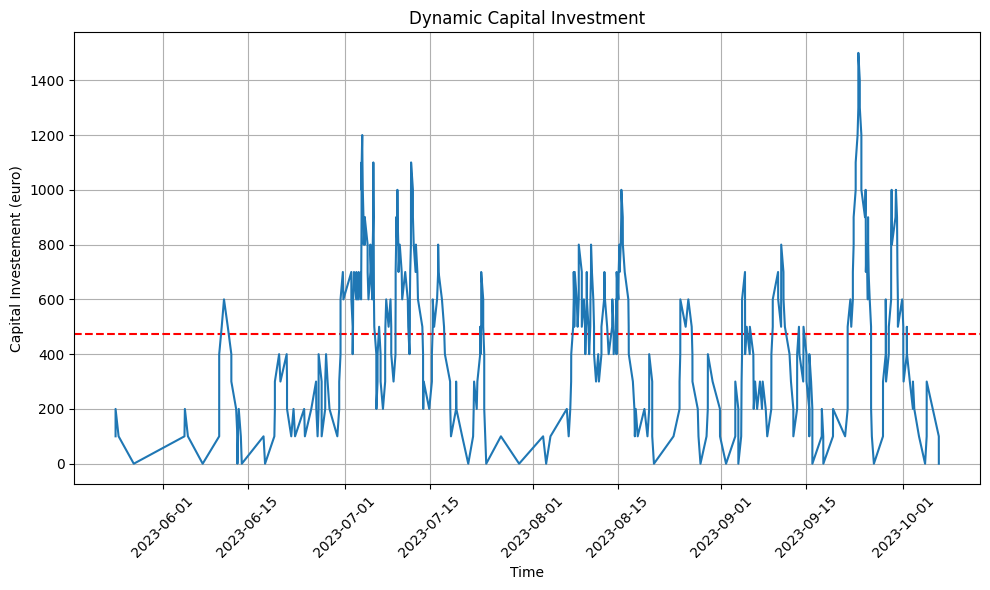

In [5]:
from Functions import check_invevestment_amount
check_invevestment_amount(info, output, investment_amount=100)

In [8]:
key = 'buy_vol_3h:0.75/vol_30m:30/timeframe:720/vlty:3'

File exists, Download from loca: /Users/albertorainieri/Projects/Personal/analysis/timeseries_json/buy_vol_3h_0.75_vol_30m_30_timeframe_720_vlty_3.json
Status Code is :  200
All data have been downloaded
0 new events for buy_vol_3h:0.75/vol_30m:30/timeframe:720/vlty:3
Event occurred at 2023-06-26T16:48:02.194629
Purchase Price: 0.0592 - buy_vol_3h: 0.75 - vol_30m: 40.02 
Max price occurred at 2023-06-26 18:53:02.393673: 0.0602 (1.69)
Min price occurred at 2023-06-26 22:01:02.197264: 0.0562 (-5.07)
Performance 1 day at the triggering event -0.02
Performance 6 hours at the triggering event 0.01
Performance 3 hours at the triggering event -0.01
Performance 1 hour at the triggering event 0.0
Performance at the end of timeseries -0.02


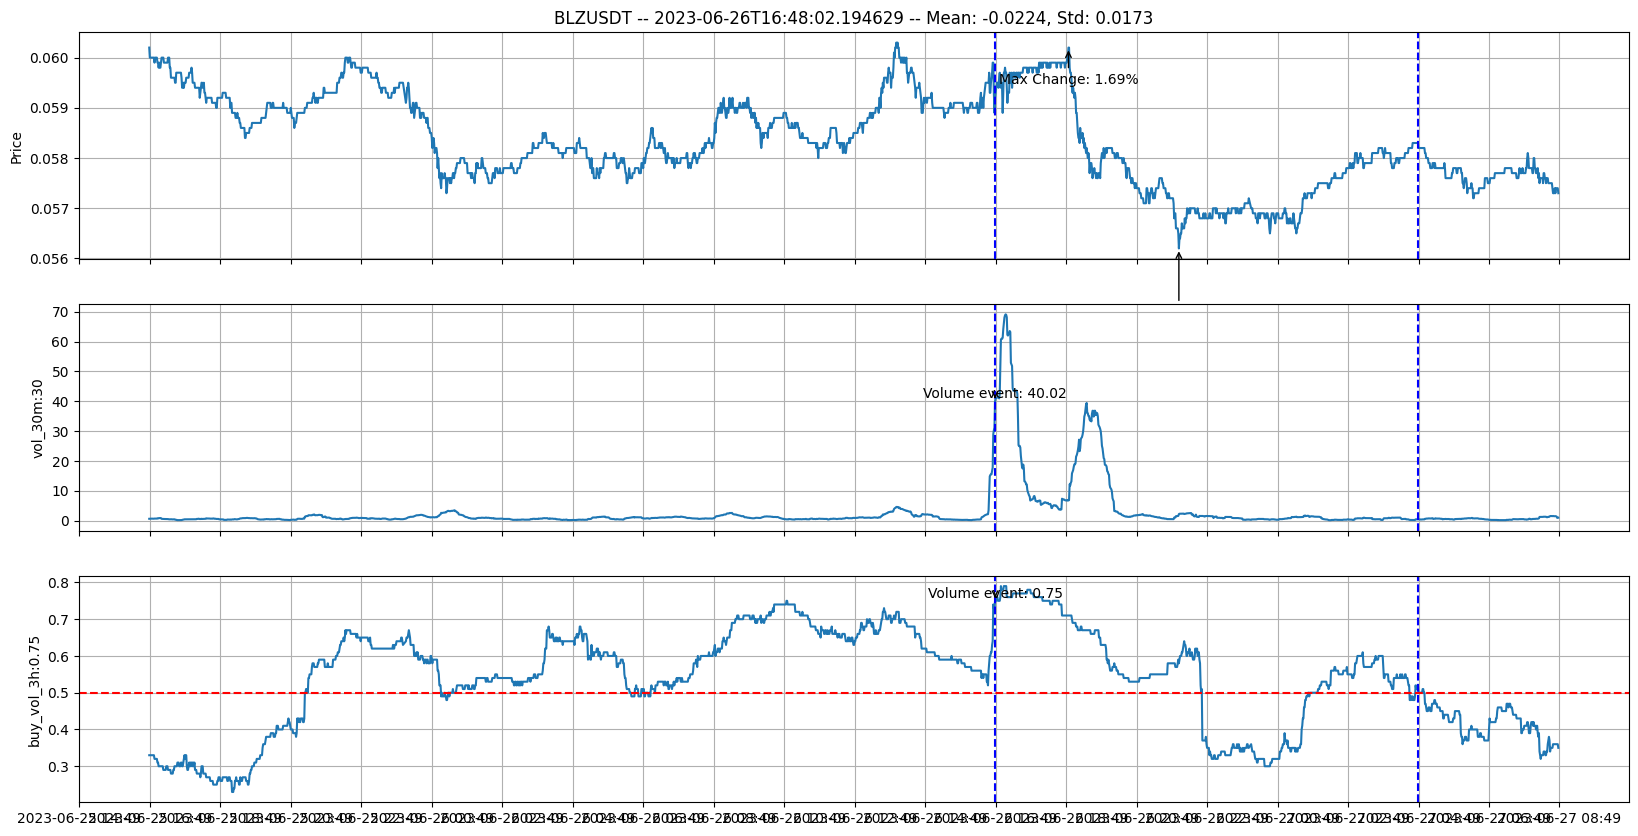

Event occurred at 2023-07-05T17:12:02.301559
Purchase Price: 43.53 - buy_vol_3h: 0.84 - vol_30m: 49.23 
Max price occurred at 2023-07-06 00:25:02.731475: 43.62 (0.21)
Min price occurred at 2023-07-05 18:44:02.311868: 42.91 (-1.42)
Performance 1 day at the triggering event -0.06
Performance 6 hours at the triggering event -0.03
Performance 3 hours at the triggering event -0.02
Performance 1 hour at the triggering event -0.02
Performance at the end of timeseries -0.0


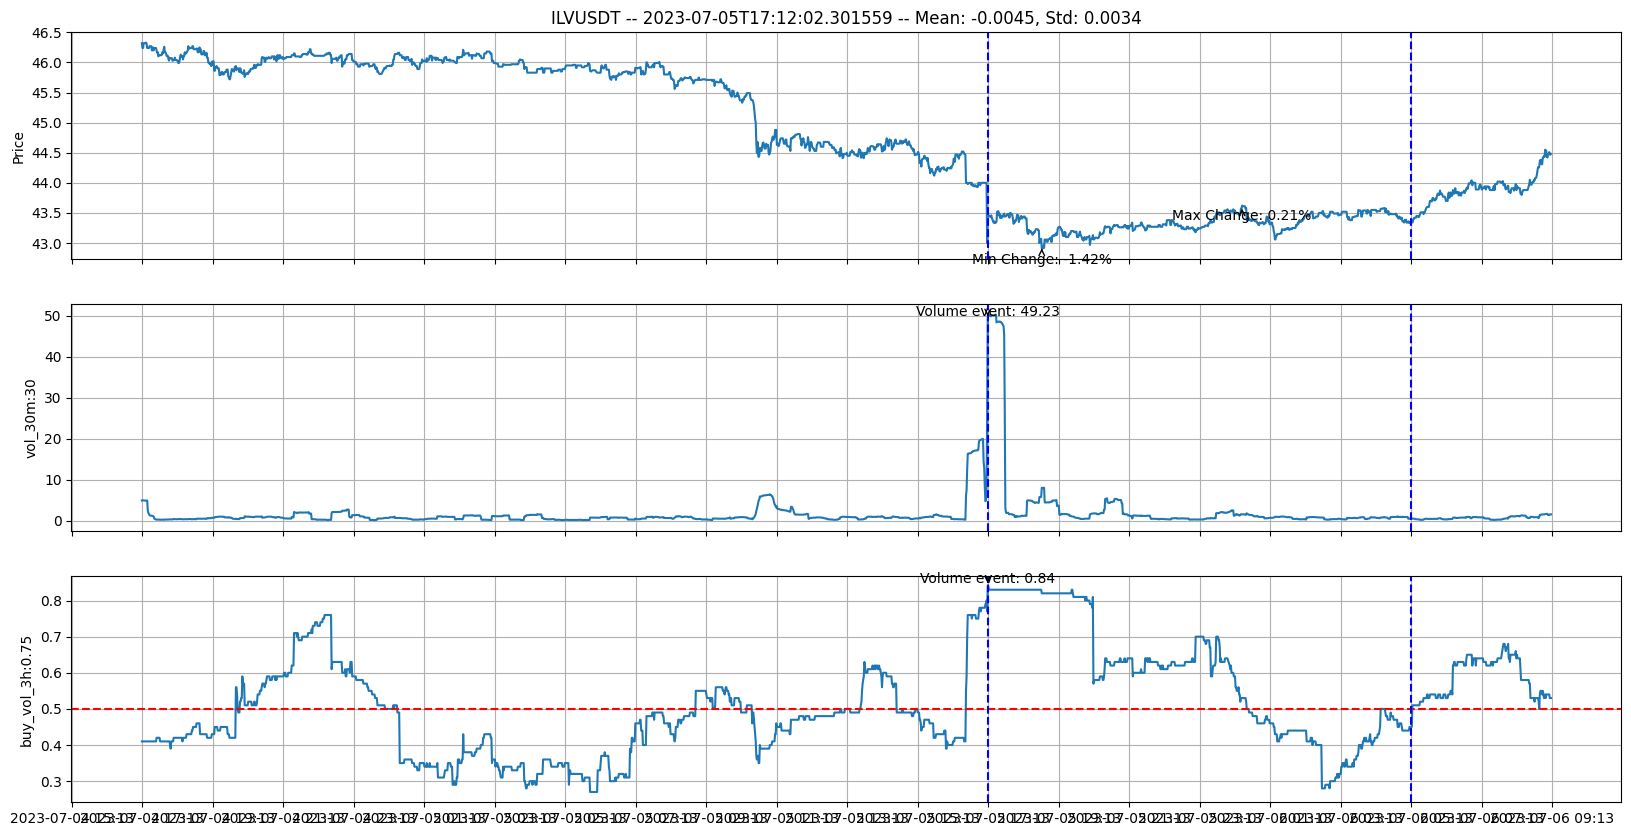

Event occurred at 2023-07-23T11:41:02.504919
Purchase Price: 0.0826 - buy_vol_3h: 0.75 - vol_30m: 31.62 
Max price occurred at 2023-07-23 18:32:02.834948: 0.1449 (75.42)
Min price occurred at 2023-07-23 11:46:02.604990: 0.0814 (-1.45)
Performance 1 day at the triggering event 0.06
Performance 6 hours at the triggering event 0.04
Performance 3 hours at the triggering event 0.05
Performance 1 hour at the triggering event 0.04
Performance at the end of timeseries 0.49


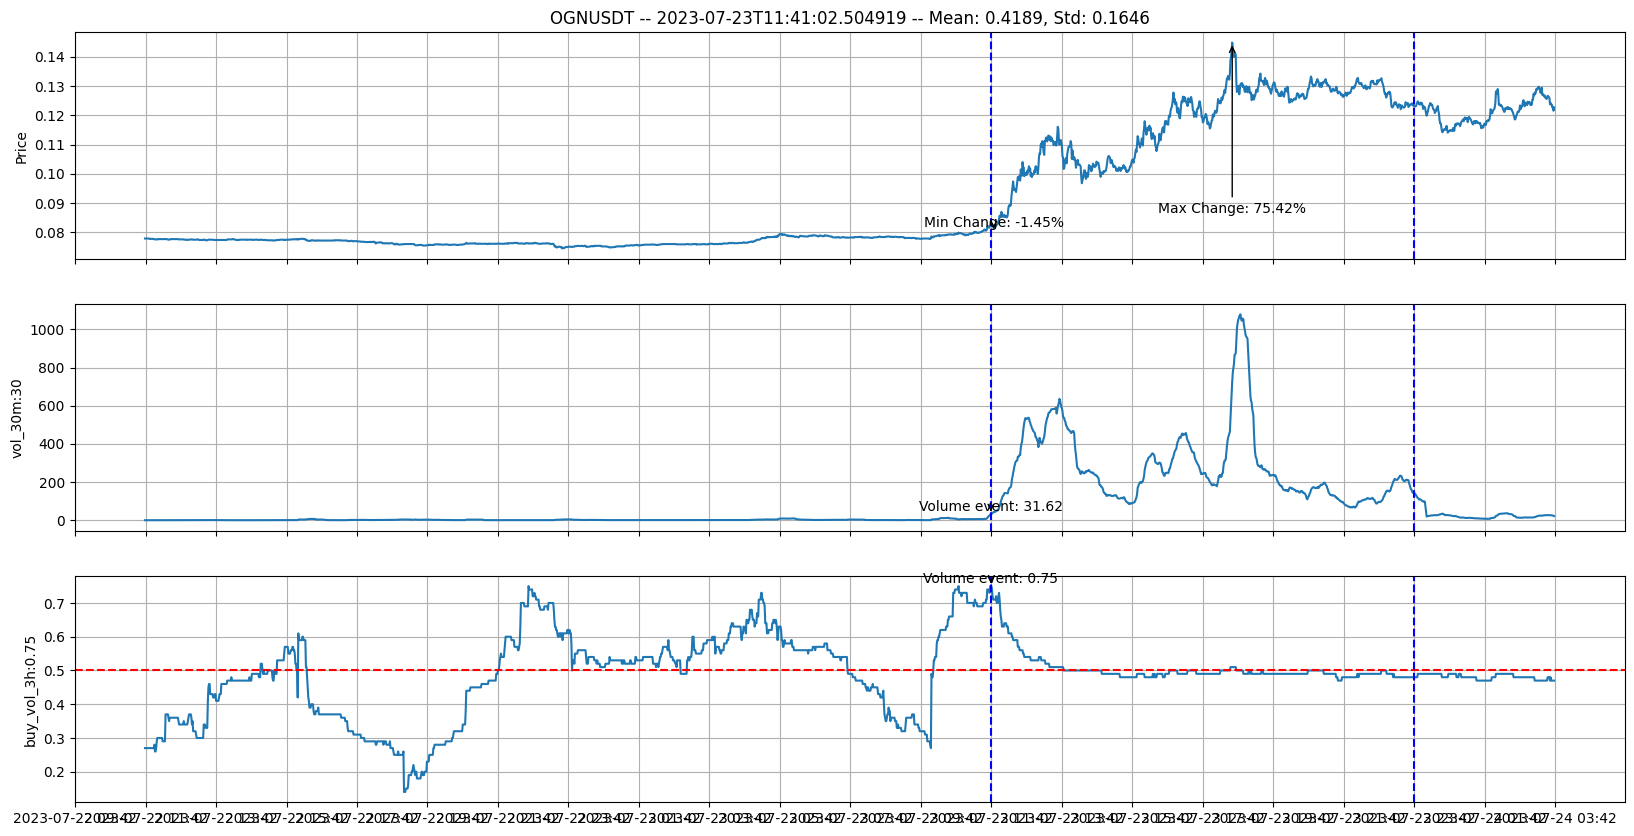

Event occurred at 2023-08-08T13:30:02.672925
Purchase Price: 0.0353 - buy_vol_3h: 0.77 - vol_30m: 33.4 
Max price occurred at 2023-08-08 14:24:02.611876: 0.0382 (8.22)
Min price occurred at 2023-08-08 13:30:02.672925: 0.0353 (0)
Performance 1 day at the triggering event 0.01
Performance 6 hours at the triggering event 0.02
Performance 3 hours at the triggering event 0.03
Performance 1 hour at the triggering event 0.02
Performance at the end of timeseries 0.03


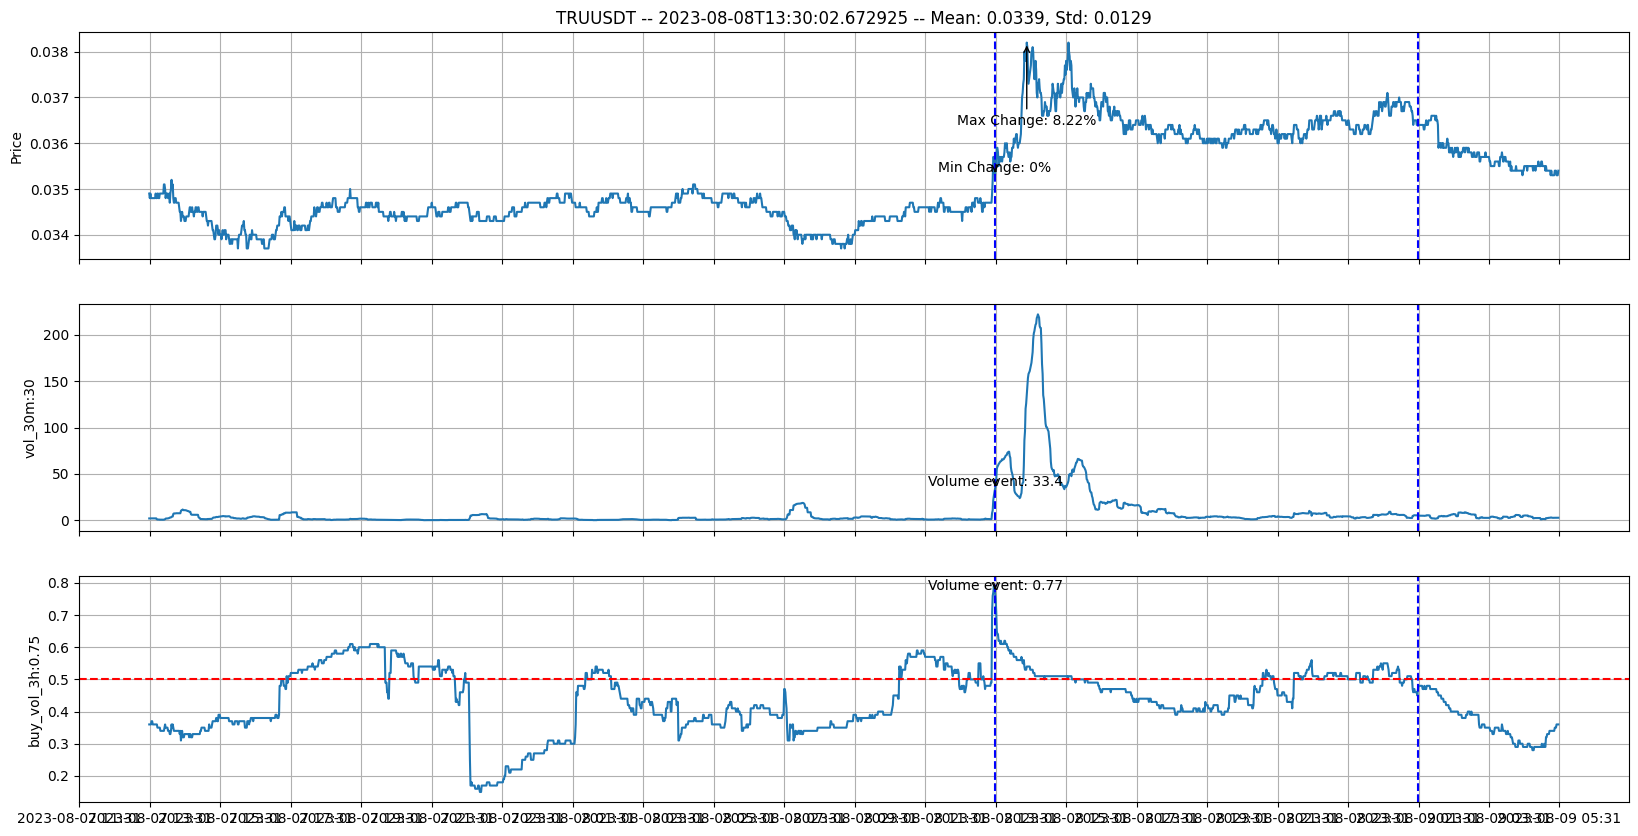

Event occurred at 2023-08-20T03:56:02.281532
Purchase Price: 0.0315 - buy_vol_3h: 0.83 - vol_30m: 33.07 
Max price occurred at 2023-08-20 09:32:02.470167: 0.0336 (6.67)
Min price occurred at 2023-08-20 15:10:02.161269: 0.0295 (-6.35)
Performance 1 day at the triggering event 0.08
Performance 6 hours at the triggering event 0.05
Performance 3 hours at the triggering event 0.04
Performance 1 hour at the triggering event 0.02
Performance at the end of timeseries -0.06


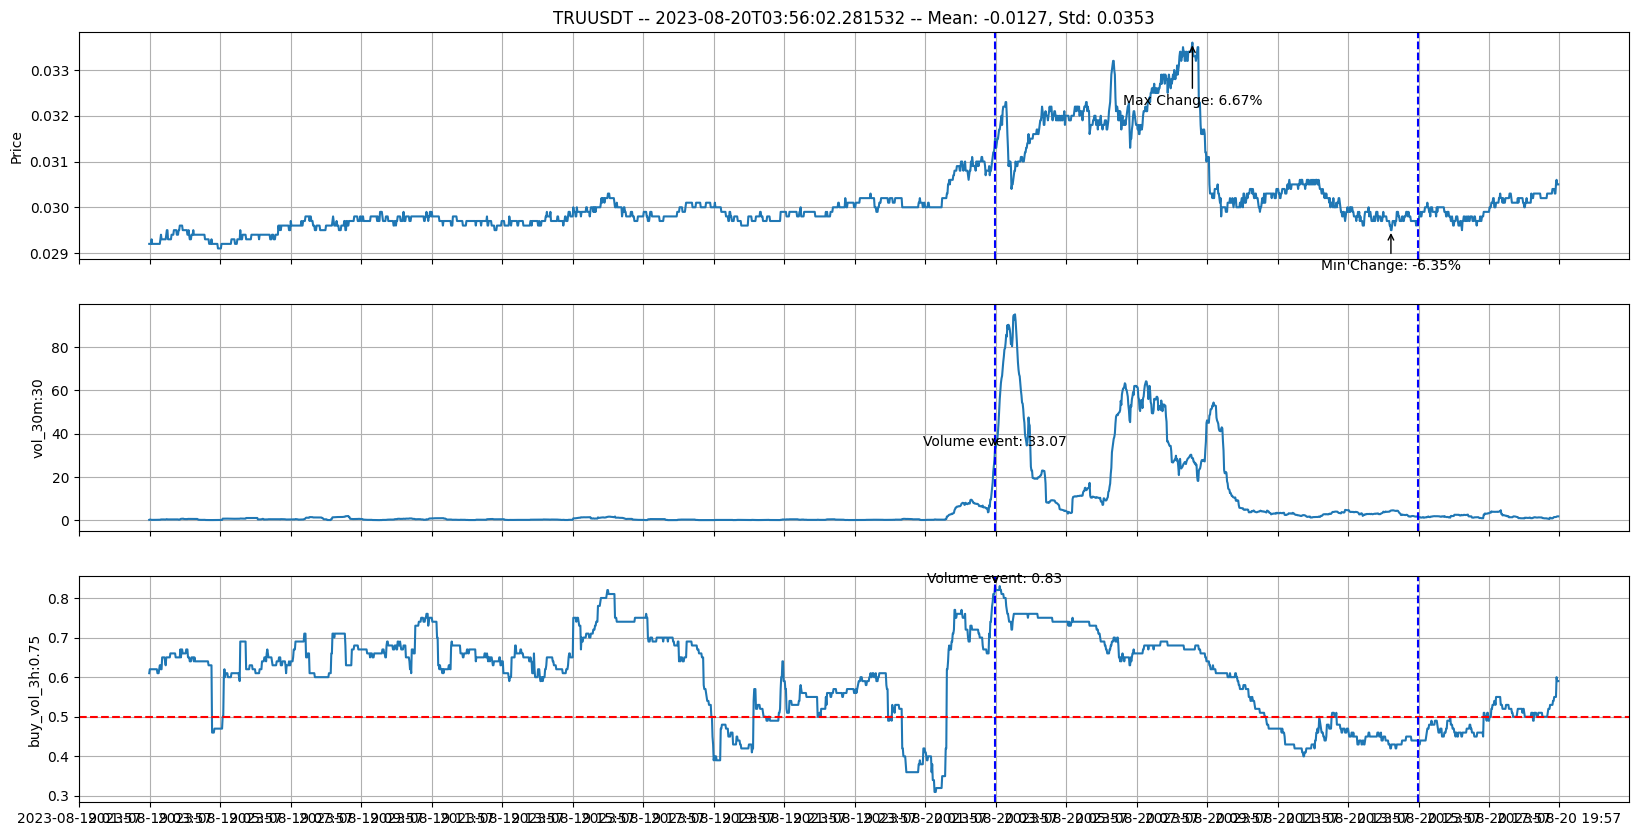

Event occurred at 2023-09-04T11:07:04.325704
Purchase Price: 1.11 - buy_vol_3h: 0.75 - vol_30m: 31.34 
Max price occurred at 2023-09-04 14:19:04.400404: 2.41 (117.12)
Min price occurred at 2023-09-04 11:08:04.740292: 1.1 (-0.9)
Performance 1 day at the triggering event 0.09
Performance 6 hours at the triggering event 0.07
Performance 3 hours at the triggering event 0.07
Performance 1 hour at the triggering event 0.07
Performance at the end of timeseries 0.91


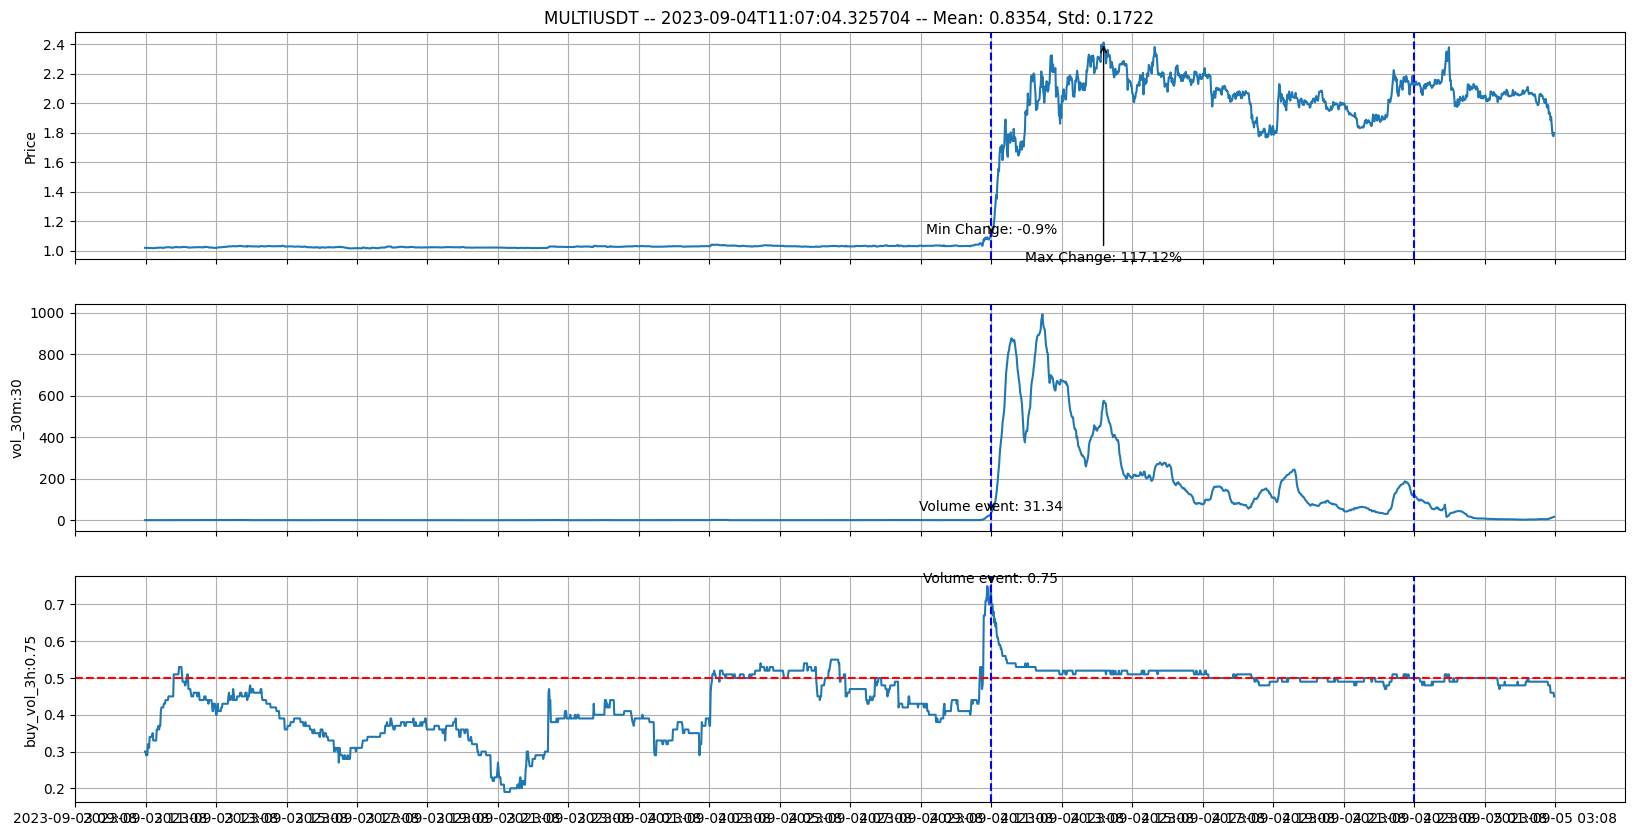

Event occurred at 2023-09-03T08:24:06.803842
Purchase Price: 0.02482 - buy_vol_3h: 0.75 - vol_30m: 31.71 
Max price occurred at 2023-09-03 08:35:06.686793: 0.0263 (5.96)
Min price occurred at 2023-09-03 15:46:06.818115: 0.02309 (-6.97)
Performance 1 day at the triggering event 0.12
Performance 6 hours at the triggering event 0.09
Performance 3 hours at the triggering event 0.08
Performance 1 hour at the triggering event 0.08
Performance at the end of timeseries -0.04


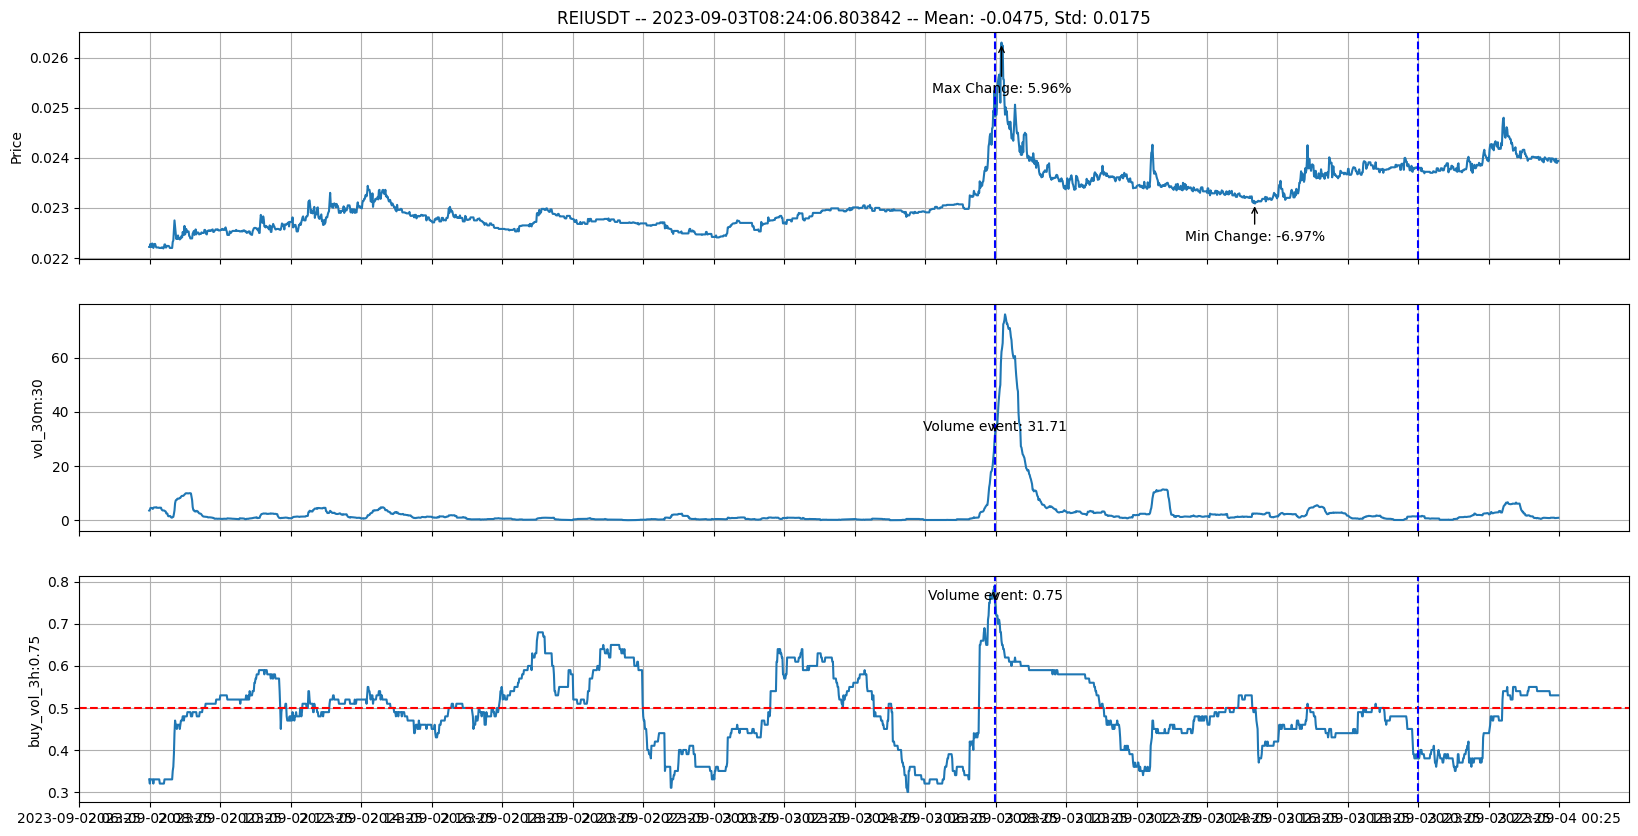

Event occurred at 2023-09-15T13:06:02.058499
Purchase Price: 0.02566 - buy_vol_3h: 0.79 - vol_30m: 32.14 
Max price occurred at 2023-09-16 00:51:02.091592: 0.02613 (1.83)
Min price occurred at 2023-09-15 13:12:02.090991: 0.02521 (-1.75)
Performance 1 day at the triggering event 0.04
Performance 6 hours at the triggering event 0.02
Performance 3 hours at the triggering event 0.02
Performance 1 hour at the triggering event 0.02
Performance at the end of timeseries 0.02


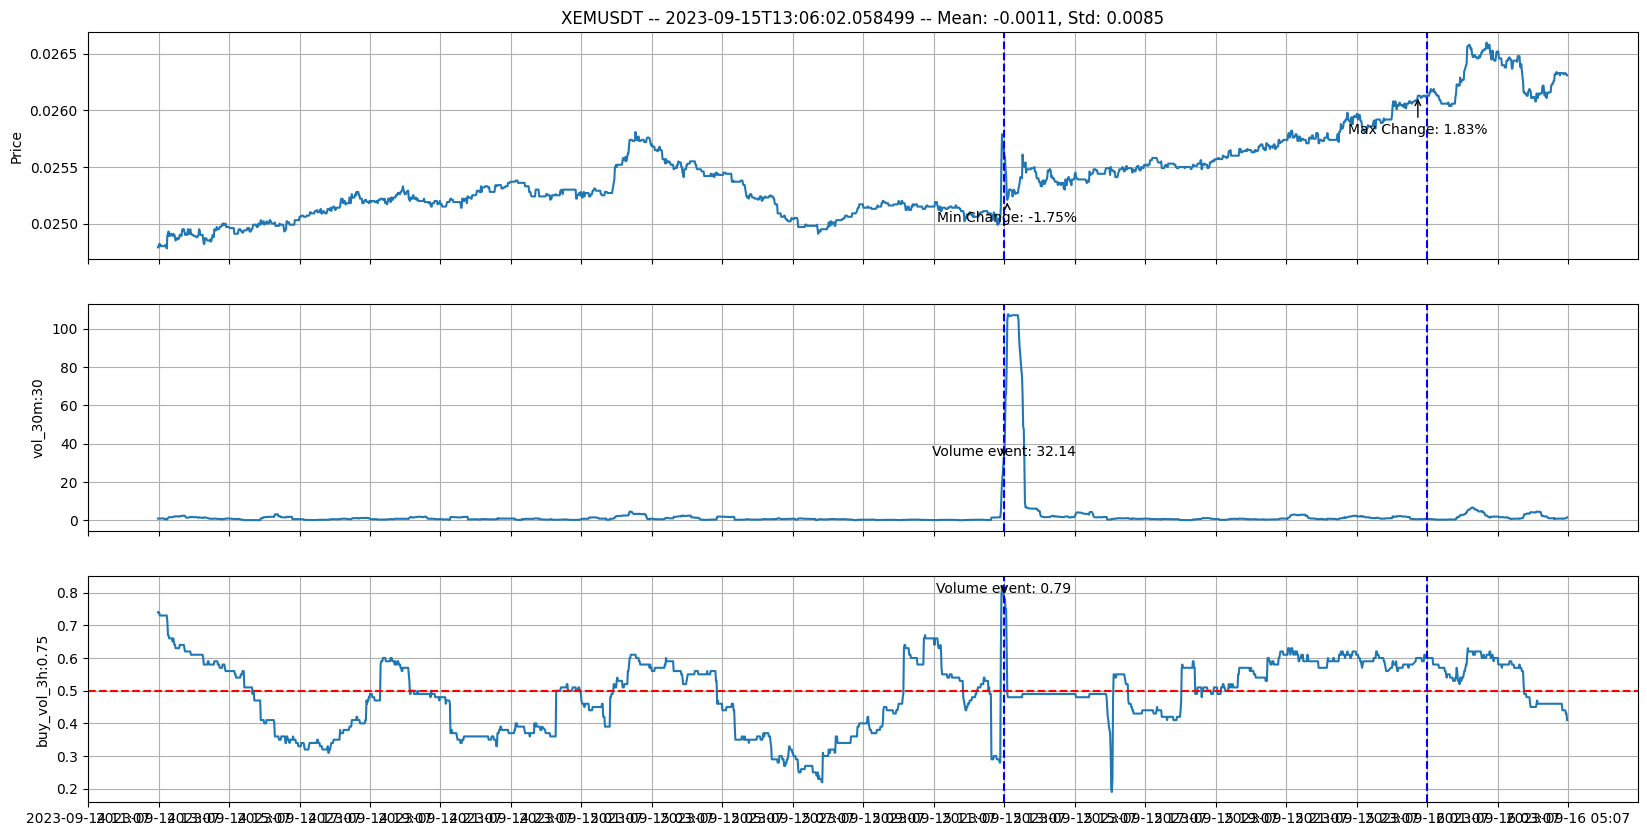

Event occurred at 2023-09-25T05:18:08.574310
Purchase Price: 4.21 - buy_vol_3h: 0.81 - vol_30m: 33.05 
Max price occurred at 2023-09-25 05:39:09.366018: 4.65 (10.45)
Min price occurred at 2023-09-25 12:15:08.901615: 4.12 (-2.14)
Performance 1 day at the triggering event 0.07
Performance 6 hours at the triggering event 0.07
Performance 3 hours at the triggering event 0.07
Performance 1 hour at the triggering event 0.07
Performance at the end of timeseries 0.02


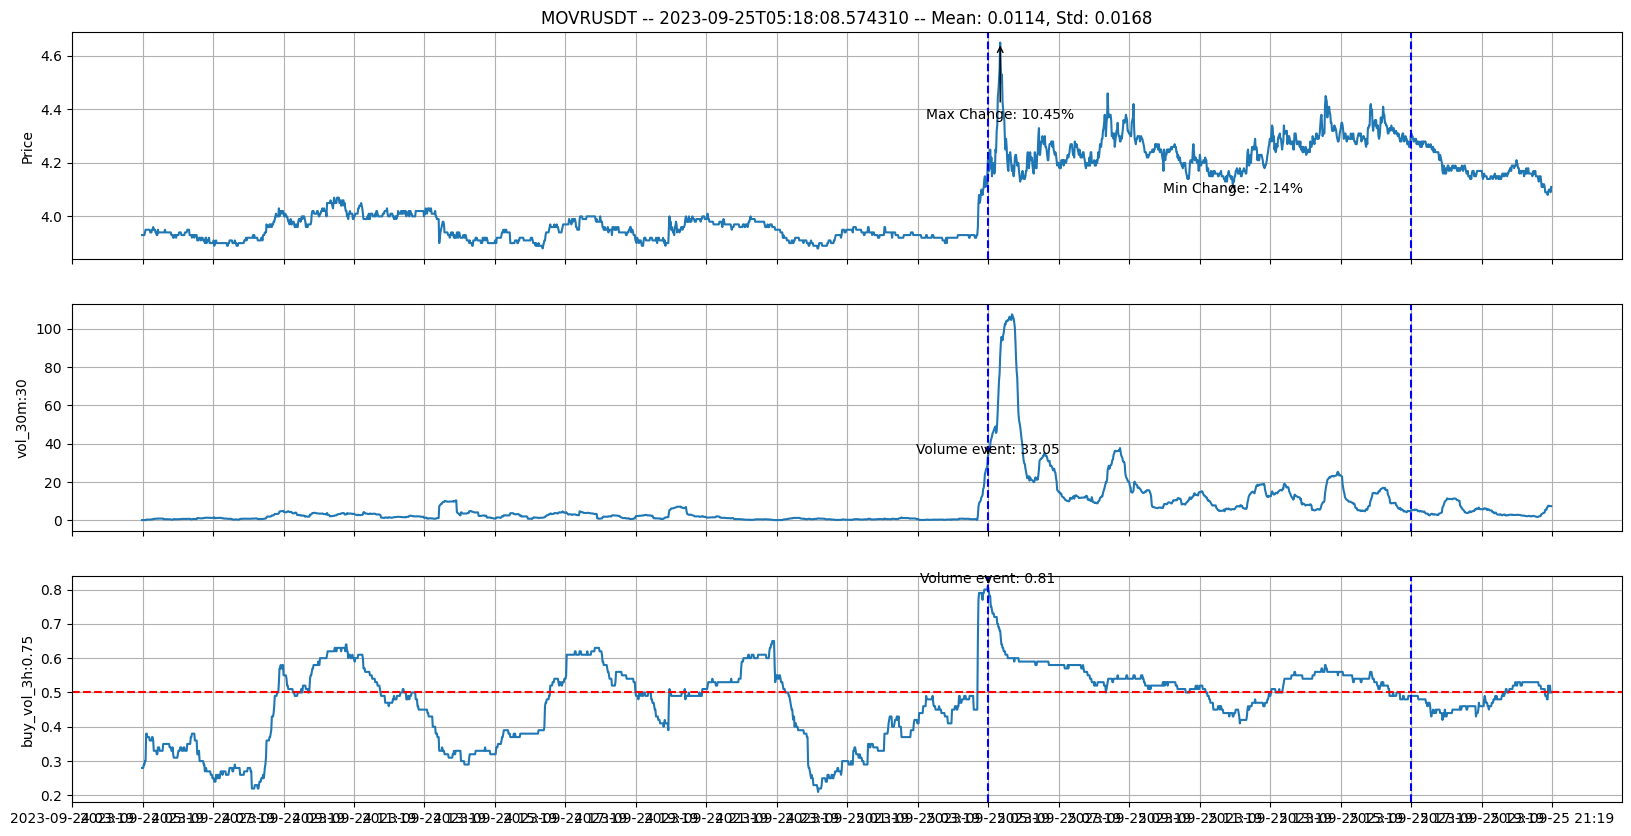

Event occurred at 2023-09-23T14:53:02.848483
Purchase Price: 2.967 - buy_vol_3h: 0.79 - vol_30m: 30.28 
Max price occurred at 2023-09-23 14:56:02.839241: 2.98 (0.44)
Min price occurred at 2023-09-24 00:58:02.849131: 2.86 (-3.61)
Performance 1 day at the triggering event 0.04
Performance 6 hours at the triggering event 0.04
Performance 3 hours at the triggering event 0.04
Performance 1 hour at the triggering event 0.04
Performance at the end of timeseries -0.01


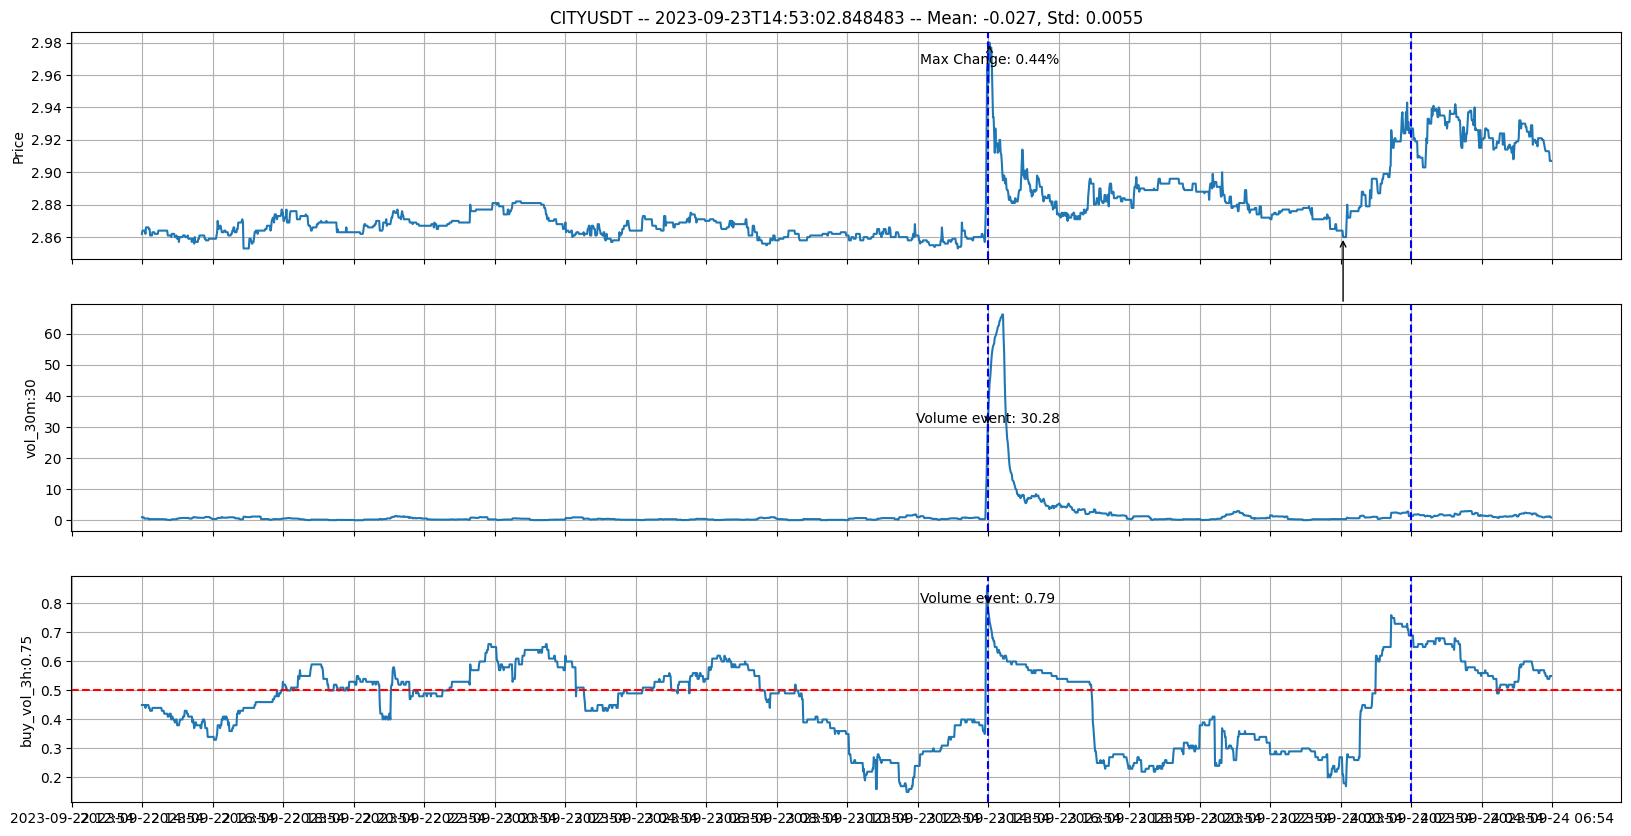

Event occurred at 2023-09-27T16:27:03.519635
Purchase Price: 16.96 - buy_vol_3h: 0.8 - vol_30m: 31.94 
Max price occurred at 2023-09-27 16:32:03.556389: 17.12 (0.94)
Min price occurred at 2023-09-27 20:54:03.654452: 15.7 (-7.43)
Performance 1 day at the triggering event 0.0
Performance 6 hours at the triggering event 0.12
Performance 3 hours at the triggering event 0.1
Performance 1 hour at the triggering event 0.11
Performance at the end of timeseries -0.02


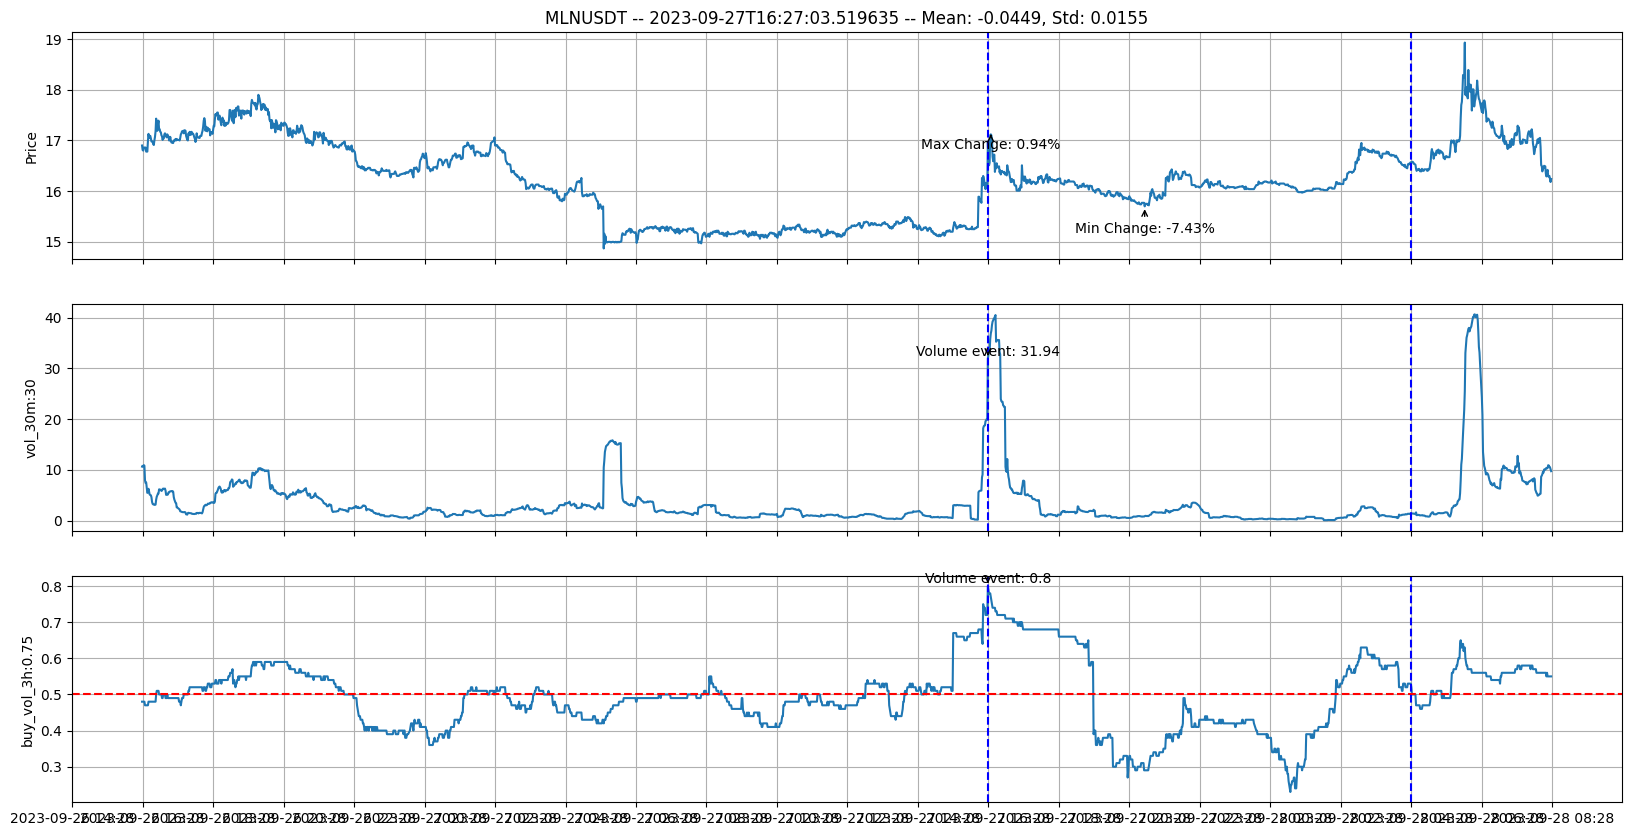

In [9]:
from Functions import getTimeseries
response = getTimeseries(info, key, check_past=1440, look_for_newdata=True, plot=True)

In [ ]:
# from Functions import getTimeseries

# key = 'buy_vol_24h:0.65/vol_6h:12/timeframe:1440/vlty:4'
# getTimeseries(info, key, check_past=1440, look_for_newdata=True, plot=True)

In [ ]:
from Functions import infoTimeseries
#key = 'buy_vol_5m:0.65/vol_24h:8/timeframe:4320/vlty:1'
timeseries_info = infoTimeseries(info, key)
timeseries_info


In [ ]:
# ANALYZE RISKMANAGEMENT FOR ONLY 1 KEY
pd.set_option('display.max_colwidth', None)

from Functions import RiskManagement
import pandas as pd
pd.set_option('display.max_rows', None)
#key = 'buy_vol_3h:0.65/vol_6h:6/timeframe:360/vlty:2'
df1, df2, best_risk_key, optimized_riskconfiguration_results = RiskManagement(key, investment_per_event=100)
df1 = df1.sort_values(by=['mean'], ascending=False)
df2 = df2.sort_values(by=['events'], ascending=True)

#result = pd.concat([df1, df2], axis=0)
print(df2)
df1

In [ ]:
info['buy_vol_5m:0.85/vol_6h:50/timeframe:1440/vlty:4']['events']

RiskManagement Path is provided
Loading analysis.json for both scenarios: OPTIMIZED or not
OPTIMIZED ANALYSIS
dict_keys(['buy_vol_5m:0.65/vol_30m:30/timeframe:720/vlty:1', 'buy_vol_5m:0.65/vol_30m:30/timeframe:4320/vlty:1', 'buy_vol_3h:0.85/vol_60m:20/timeframe:1440/vlty:6', 'buy_vol_60m:0.65/vol_6h:10/timeframe:4320/vlty:2', 'buy_vol_60m:0.65/vol_6h:12/timeframe:4320/vlty:2', 'buy_vol_5m:0.85/vol_60m:50/timeframe:2880/vlty:4', 'buy_vol_5m:0.85/vol_6h:50/timeframe:1440/vlty:4', 'buy_vol_3h:0.65/vol_6h:20/timeframe:720/vlty:5', 'buy_vol_30m:0.75/vol_15m:50/timeframe:720/vlty:3', 'buy_vol_3h:0.75/vol_30m:30/timeframe:720/vlty:3', 'buy_vol_3h:0.75/vol_60m:15/timeframe:360/vlty:3', 'buy_vol_30m:0.75/vol_6h:10/timeframe:4320/vlty:2', 'buy_vol_6h:0.65/vol_3h:20/timeframe:1440/vlty:4', 'buy_vol_15m:0.85/vol_3h:12/timeframe:4320/vlty:7'])
Loading data from analysis.json
File exists, Download from loca: /Users/albertorainieri/Projects/Personal/analysis/timeseries_json/buy_vol_60m_0.65_vol_6h_10

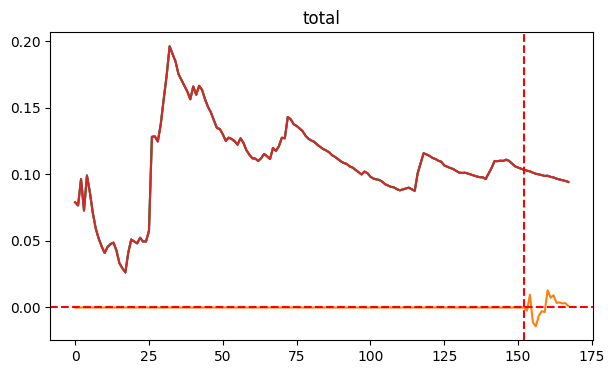

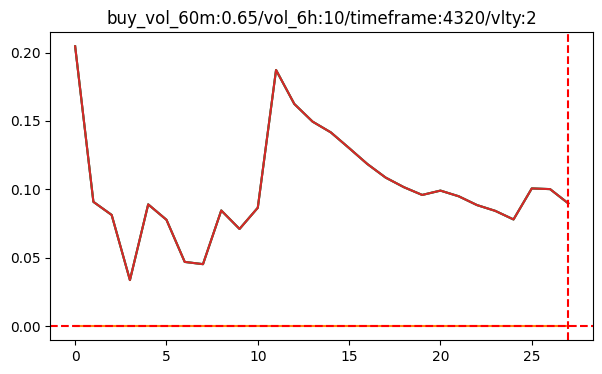

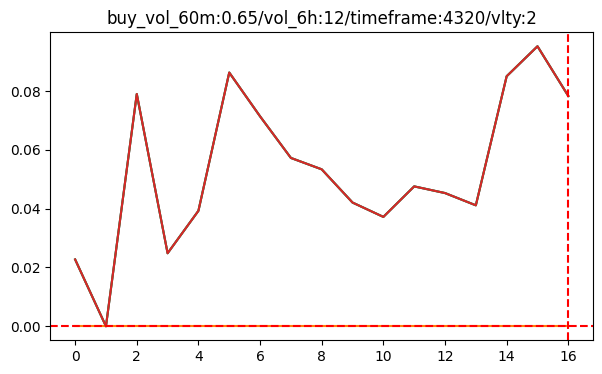

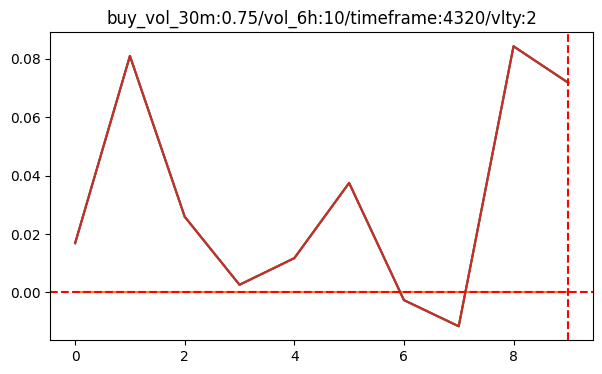

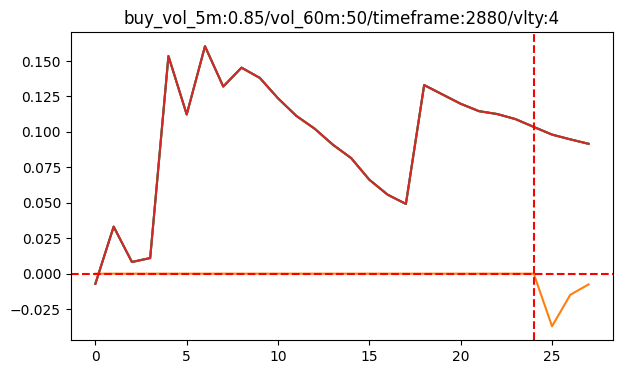

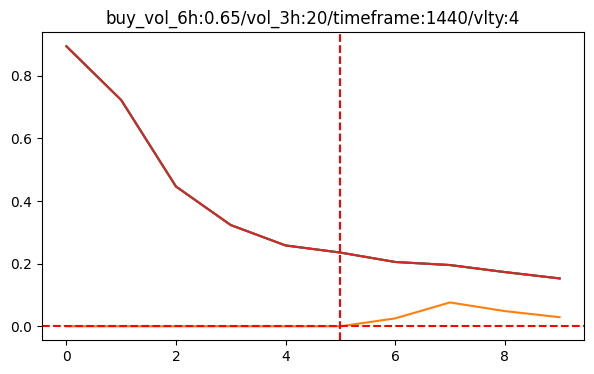

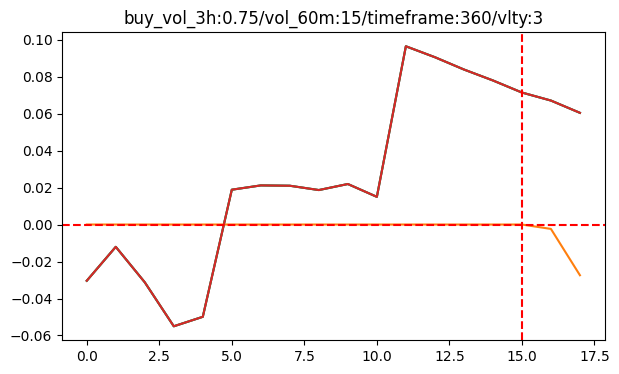

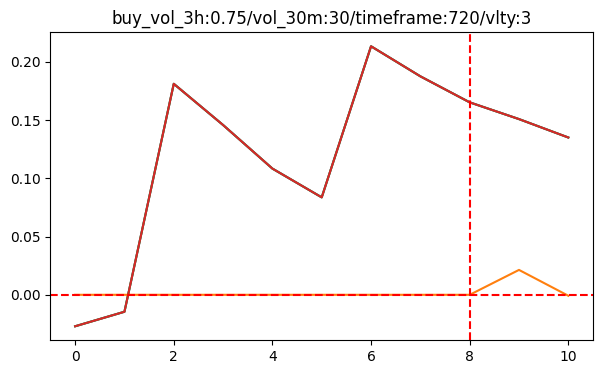

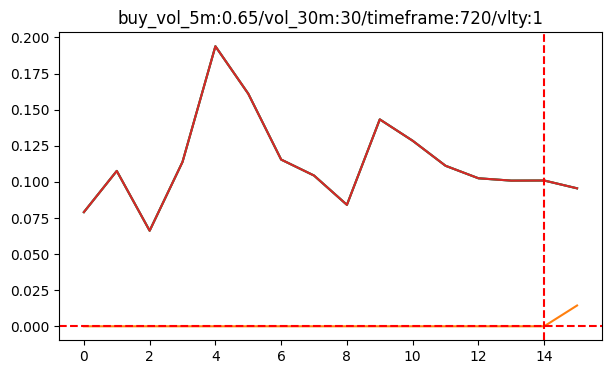

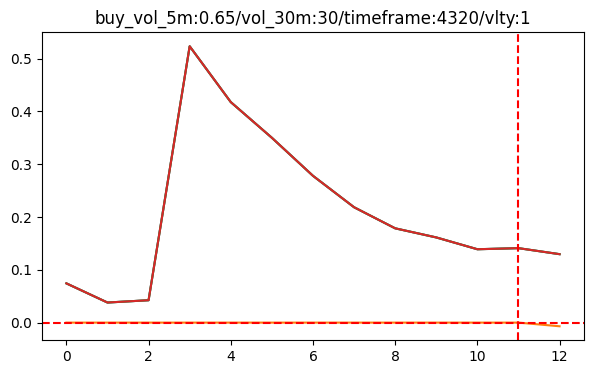

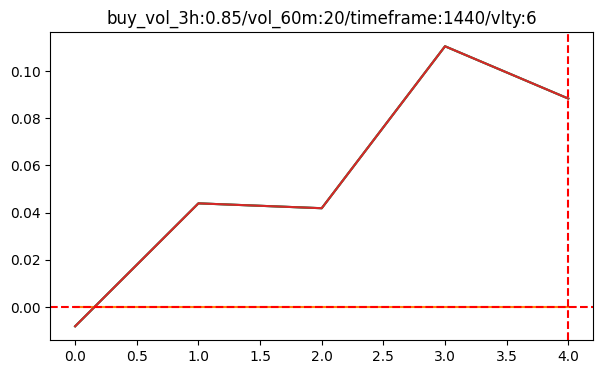

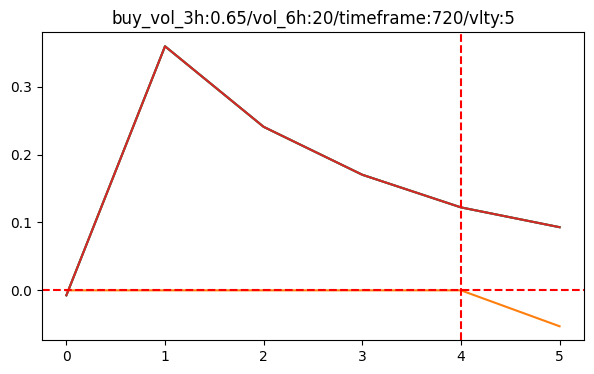

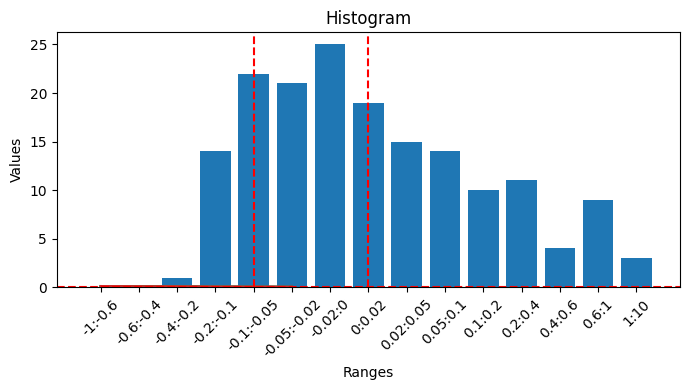

Positive events: 84
Negative events: 84
Biggest Drop: 69.16 at 2023-08-29T14:40:05.647409


,event,mean_series,mean_event,balance,coin,event_key,price_%_1d,price_%_6h,price_%_3h,price_%_1h,buy_price,exit_price,timestamp_exit
0,2023-05-24T05:59:02.689721,0.079037,0.079037,1007.90,ARPAUSDT,buy_vol_5m:0.65/vol_30m:30/timeframe:720/vlty:1,0.6740,0.1637,0.1249,0.0719,0.100080,0.107990,2023-05-24T15:36:02.796321
1,2023-05-24T05:59:02.689721,0.076689,0.074341,1015.33,ARPAUSDT,buy_vol_5m:0.65/vol_30m:30/timeframe:4320/vlty:1,-0.0123,0.0267,0.0192,-0.0412,0.100080,0.107520,2023-05-26T15:36:02.390903
2,2023-06-04T14:26:02.654283,0.096478,0.136057,1028.94,LUNCUSDT,buy_vol_5m:0.65/vol_30m:30/timeframe:720/vlty:1,0.3061,-0.0124,0.0038,-0.0079,0.000098,0.000111,2023-06-05T00:03:02.440406
3,2023-06-04T14:26:02.654283,0.072794,0.001740,1029.11,LUNCUSDT,buy_vol_5m:0.65/vol_30m:30/timeframe:4320/vlty:1,0.0682,-0.0116,-0.0018,-0.0076,0.000098,0.000098,2023-06-07T00:04:02.230400
4,2023-06-10T07:44:02.820154,0.099144,0.204545,1049.56,ADAUPUSDT,buy_vol_60m:0.65/vol_6h:10/timeframe:4320/vlty:2,0.0291,-0.0364,-0.0450,-0.0185,0.088000,0.106000,2023-06-12T17:20:02.902514
5,2023-06-10T07:44:02.820154,0.086408,0.022727,1051.83,ADAUPUSDT,buy_vol_60m:0.65/vol_6h:12/timeframe:4320/vlty:2,0.0291,-0.0364,-0.0450,-0.0185,0.088000,0.090000,2023-06-10T13:03:02.373516
6,2023-06-10T07:46:02.780527,0.070817,-0.022727,1049.56,SUSHIUSDT,buy_vol_60m:0.65/vol_6h:10/timeframe:4320/vlty:2,-0.0261,-0.0176,-0.0089,-0.0089,0.572000,0.559000,2023-06-12T17:23:02.770180
7,2023-06-10T07:46:02.780527,0.059124,-0.022727,1047.29,SUSHIUSDT,buy_vol_60m:0.65/vol_6h:12/timeframe:4320/vlty:2,-0.0261,-0.0176,-0.0089,-0.0089,0.572000,0.559000,2023-06-12T17:23:02.770180
8,2023-06-10T17:41:02.414171,0.051649,-0.008152,1046.47,GNOUSDT,buy_vol_3h:0.85/vol_60m:20/timeframe:1440/vlty:6,0.0046,0.0009,0.0009,-0.0036,110.400000,109.500000,2023-06-11T12:53:02.532959
9,2023-06-11T02:41:02.880311,0.045770,-0.007141,1045.76,STPTUSDT,buy_vol_5m:0.85/vol_60m:50/timeframe:2880/vlty:4,-0.0186,-0.0100,0.0023,0.0049,0.035010,0.034760,2023-06-12T17:06:02.835604


In [1]:
# EARLY VALIDATION ANALYSIS
# ANALYZE THE RISKMANAGEMENT OF ALL KEYS FROM INFO UNTIL A CERTAIN DATE
from Functions import earlyValidation
import pandas as pd
from datetime import datetime
pd.set_option('display.max_rows', None)

# minimum_event_number_list MUST BE a list IN REVERSE ORDER
minimum_event_number_list = [50, 35, 25, 15, 10, 5]
minimum_coin_number = 0
mean_threshold = 3
lb_threshold = -15
frequency_threshold = 1
group_coins = False
best_coins_volatility = 5
early_validation = datetime(2023,9,21)

optimized_gain_threshold = 5
mean_gain_threshold = 3
riskmanagement_conf = (minimum_event_number_list, minimum_coin_number, mean_threshold, lb_threshold, frequency_threshold, group_coins, best_coins_volatility)
riskmanagement_path = '/Users/albertorainieri/Projects/Personal/analysis/riskmanagement_backup/riskmanagement-2023-9-27-[50, 35, 25, 15, 5]-3-212.json'
#riskmanagement_path = False
std_multiplier = 3
OPTIMIZED=True
DISCOVER=True

df = earlyValidation(minimum_event_number_list, minimum_coin_number, mean_threshold, lb_threshold, frequency_threshold, optimized_gain_threshold,
                     mean_gain_threshold, group_coins, best_coins_volatility, early_validation, OPTIMIZED, DISCOVER, riskmanagement_path, std_multiplier)
df

In [ ]:
from Functions import PriceVariation_analysis
model_type = 'linear_regression'
model_type = 'svc'
PriceVariation_analysis(df, model_type=model_type)


In [12]:
# ANALYZE THE RISKMANAGEMENT OF ALL KEYS FROM INFO 
from Functions import RiskConfiguration
optimized_gain_threshold = 5
mean_gain_threshold = 3
DISCOVER=True

riskmanagement_conf = (minimum_event_number_list, minimum_coin_number, mean_threshold, lb_threshold, frequency_threshold, group_coins, best_coins_volatility)
df, none_riskmanagement_path  = RiskConfiguration(info, riskmanagement_conf, optimized_gain_threshold, mean_gain_threshold, DISCOVER=DISCOVER)
df

18 keys will be analyzed in terms of risk configuration
buy_vol_60m:0.65/vol_6h:10/timeframe:4320/vlty:2
ITERATION 1 has started
File exists, Download from loca: /Users/albertorainieri/Projects/Personal/analysis/timeseries_json/buy_vol_60m_0.65_vol_6h_10_timeframe_4320_vlty_2.json
Status Code is :  200
All data have been downloaded
0 new events for buy_vol_60m:0.65/vol_6h:10/timeframe:4320/vlty:2
Number of combinations 77
253.02 euro of profit for an investment of 100 euro per event (total of 28 events). risk_golden_zone:0.1_step:0.15_step_no_golden:0.01_extratime:0.0 with 9.04 %
buy_vol_3h:0.75/vol_60m:10/timeframe:720/vlty:3
ITERATION 2 has started
File does not exist, Download from server...
Status Code is :  200
All data have been downloaded
Number of combinations 77
127.5 euro of profit for an investment of 100 euro per event (total of 26 events). risk_golden_zone:1_step:0.05_step_no_golden:0.01_extratime:0.0 with 4.9 %
buy_vol_5m:0.85/vol_60m:50/timeframe:2880/vlty:4
ITERATION 3 

,keys,golden_zone,step_golden,step_nogolden,extra_timeframe,optimized_gain,optimized_std,mean_gain,median_gain,std_gain,frequency,n_events
10,buy_vol_3h:0.65/vol_3h:30/timeframe:2880/vlty:4,1,0.05,0.01,0.0,39.95,64.92,26.17,28.60,46.10,1.78,6
3,buy_vol_30m:0.75/vol_6h:12/timeframe:4320/vlty:2,0.1,0.075,0.01,0.0,22.83,24.30,14.36,14.60,24.70,1.79,5
8,buy_vol_3h:0.65/vol_3h:20/timeframe:2880/vlty:4,0.7,0.05,0.01,0.0,17.40,45.25,11.83,13.33,34.49,4.21,15
9,buy_vol_6h:0.65/vol_3h:20/timeframe:1440/vlty:4,1,0.05,0.01,0.0,15.01,30.41,11.00,12.36,22.50,3.23,10
6,buy_vol_60m:0.75/vol_6h:20/timeframe:2880/vlty:3,1,0.05,0.01,0.0,14.24,28.49,12.87,14.14,25.76,2.73,5
5,buy_vol_3h:0.75/vol_30m:30/timeframe:720/vlty:3,1,0.05,0.01,0.0,13.35,32.03,9.65,10.48,23.62,3.59,11
12,buy_vol_5m:0.65/vol_30m:30/timeframe:4320/vlty:1,0.25,0.25,0.01,0.0,13.00,53.87,6.20,5.45,29.94,3.07,13
11,buy_vol_5m:0.65/vol_60m:30/timeframe:720/vlty:1,0.8,0.075,0.01,0.0,12.00,26.90,9.16,9.15,21.32,3.54,15
0,buy_vol_60m:0.65/vol_6h:10/timeframe:4320/vlty:2,0.1,0.15,0.01,0.0,9.04,29.21,5.90,5.71,24.87,8.08,28
7,buy_vol_5m:0.85/vol_60m:50/timeframe:2880/vlty:4,0.6,0.15,0.01,0.0,9.01,34.54,6.51,7.01,26.80,7.30,28


In [13]:
from Functions import load_riskconfiguration
#another_riskconfiguration = "/Users/albertorainieri/Projects/Personal/analysis/riskmanagement_backup/riskmanagement-2-8-2023-10-3-717.json"

another_riskconfiguration = None

df = load_riskconfiguration(another_riskconfiguration)
df

Total events per month on average: 63
Optimized gain each month (percentage) for each event: 0.1132557777777778 euro with investment amount 100 euro per event
Optimized gain each month: 713 euro with investment amount 100 euro per event
Mean gain each month (percentage) for each event: 0.07735912698412697 euro with investment amount 100 euro per event
Mean gain each month: 487 euro with investment amount 100 euro per event
{
    "minimum_event_number": [
        50,
        35,
        25,
        15,
        10,
        5
    ],
    "minimum_coin_number": 0,
    "mean_threshold": 3,
    "lb_threshold": -15,
    "frequency_threshold": 1,
    "group_coins": false,
    "best_coins_volatility": 5,
    "timestamp": "2023-10-09T17:58:23.205141"
}


,keys,golden_zone,step_golden,step_nogolden,extra_timeframe,optimized_gain,optimized_std,mean_gain,median_gain,std_gain,frequency,n_events
10,buy_vol_3h:0.65/vol_3h:30/timeframe:2880/vlty:4,1,0.05,0.01,0.0,39.95,64.92,26.17,28.60,46.10,1.78,6
3,buy_vol_30m:0.75/vol_6h:12/timeframe:4320/vlty:2,0.1,0.075,0.01,0.0,22.83,24.30,14.36,14.60,24.70,1.79,5
8,buy_vol_3h:0.65/vol_3h:20/timeframe:2880/vlty:4,0.7,0.05,0.01,0.0,17.40,45.25,11.83,13.33,34.49,4.21,15
9,buy_vol_6h:0.65/vol_3h:20/timeframe:1440/vlty:4,1,0.05,0.01,0.0,15.01,30.41,11.00,12.36,22.50,3.23,10
6,buy_vol_60m:0.75/vol_6h:20/timeframe:2880/vlty:3,1,0.05,0.01,0.0,14.24,28.49,12.87,14.14,25.76,2.73,5
5,buy_vol_3h:0.75/vol_30m:30/timeframe:720/vlty:3,1,0.05,0.01,0.0,13.35,32.03,9.65,10.48,23.62,3.59,11
12,buy_vol_5m:0.65/vol_30m:30/timeframe:4320/vlty:1,0.25,0.25,0.01,0.0,13.00,53.87,6.20,5.45,29.94,3.07,13
11,buy_vol_5m:0.65/vol_60m:30/timeframe:720/vlty:1,0.8,0.075,0.01,0.0,12.00,26.90,9.16,9.15,21.32,3.54,15
0,buy_vol_60m:0.65/vol_6h:10/timeframe:4320/vlty:2,0.1,0.15,0.01,0.0,9.04,29.21,5.90,5.71,24.87,8.08,28
7,buy_vol_5m:0.85/vol_60m:50/timeframe:2880/vlty:4,0.6,0.15,0.01,0.0,9.01,34.54,6.51,7.01,26.80,7.30,28


In [16]:
from Functions import send_riskconfiguration
response = send_riskconfiguration()

Status Code is :  200


Loading analysis.json for both scenarios: OPTIMIZED or not
OPTIMIZED ANALYSIS
dict_keys(['buy_vol_5m:0.65/vol_30m:30/timeframe:4320/vlty:1', 'buy_vol_5m:0.65/vol_60m:30/timeframe:720/vlty:1', 'buy_vol_3h:0.85/vol_60m:20/timeframe:1440/vlty:6', 'buy_vol_60m:0.65/vol_6h:12/timeframe:2880/vlty:2', 'buy_vol_60m:0.65/vol_6h:10/timeframe:4320/vlty:2', 'buy_vol_3h:0.75/vol_60m:10/timeframe:720/vlty:3', 'buy_vol_5m:0.85/vol_60m:50/timeframe:2880/vlty:4', 'buy_vol_15m:0.75/vol_3h:50/timeframe:360/vlty:5', 'buy_vol_3h:0.65/vol_3h:20/timeframe:2880/vlty:4', 'buy_vol_3h:0.65/vol_3h:30/timeframe:2880/vlty:4', 'buy_vol_3h:0.75/vol_30m:30/timeframe:720/vlty:3', 'buy_vol_3h:0.75/vol_60m:15/timeframe:720/vlty:3', 'buy_vol_30m:0.75/vol_6h:10/timeframe:2880/vlty:2', 'buy_vol_30m:0.75/vol_6h:12/timeframe:4320/vlty:2', 'buy_vol_60m:0.75/vol_6h:20/timeframe:2880/vlty:3', 'buy_vol_60m:0.75/vol_3h:20/timeframe:360/vlty:5', 'buy_vol_6h:0.65/vol_3h:20/timeframe:1440/vlty:4', 'buy_vol_15m:0.85/vol_3h:12/timefram

/opt/homebrew/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


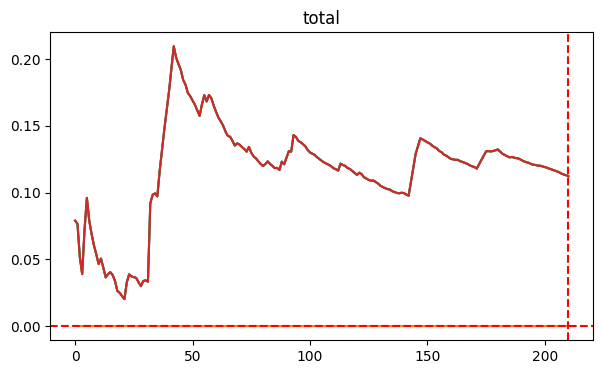

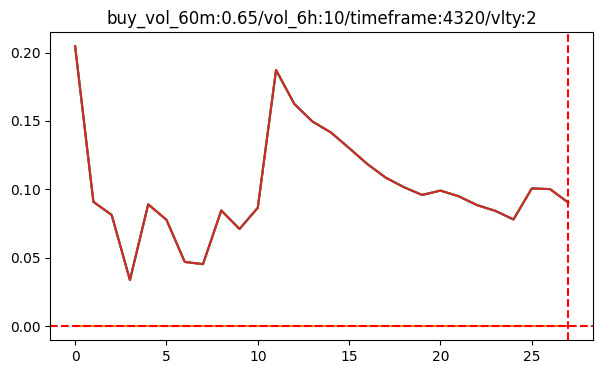

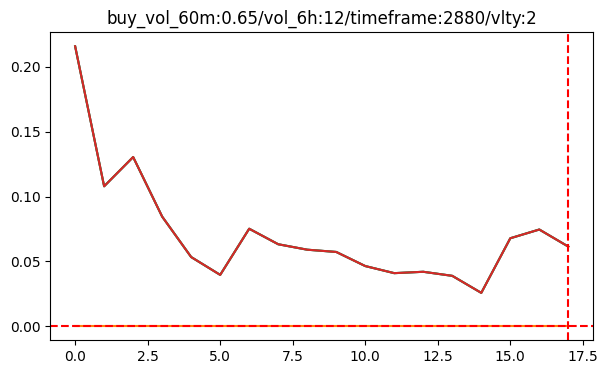

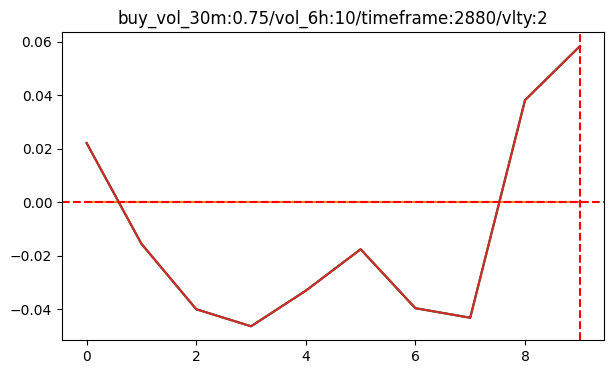

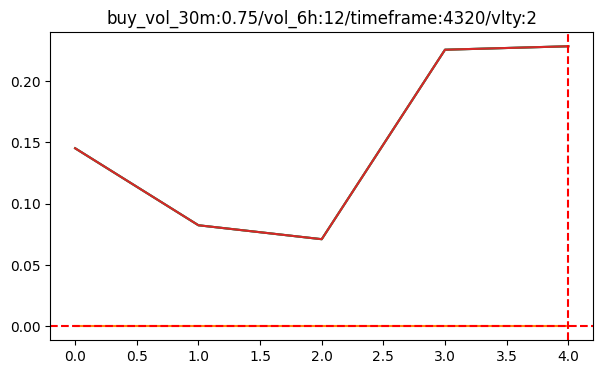

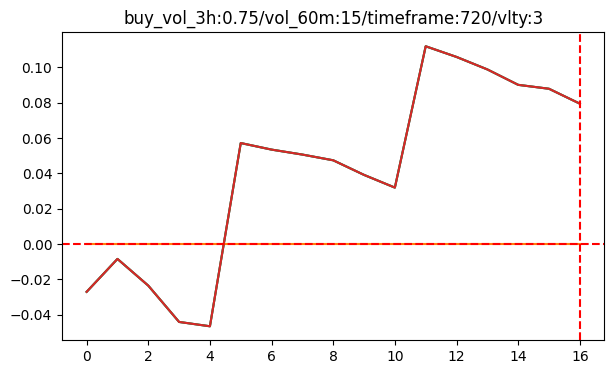

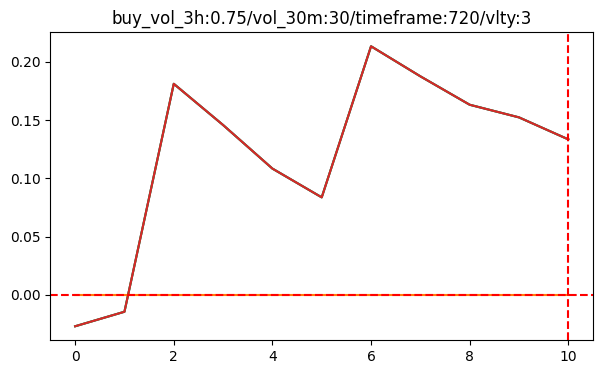

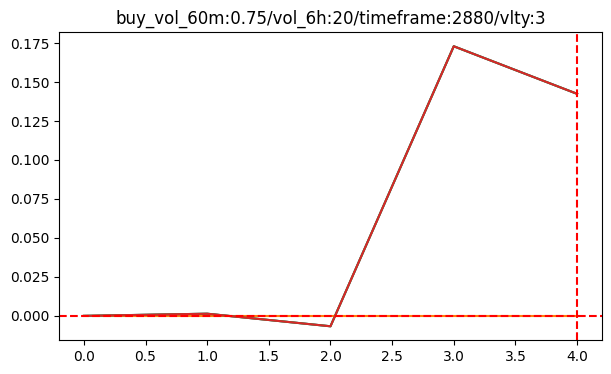

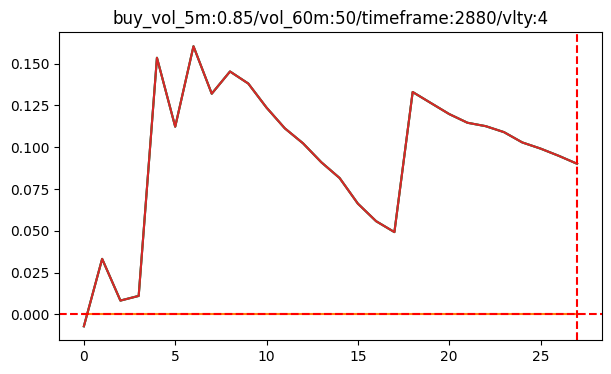

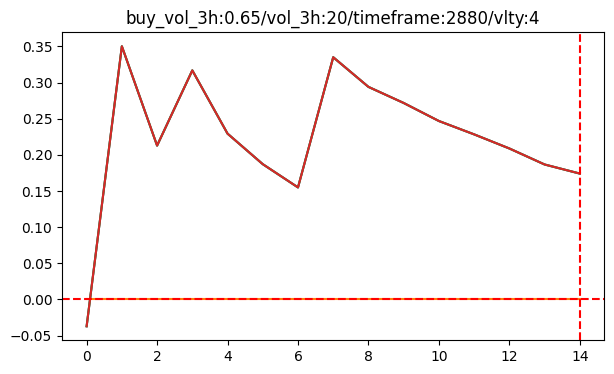

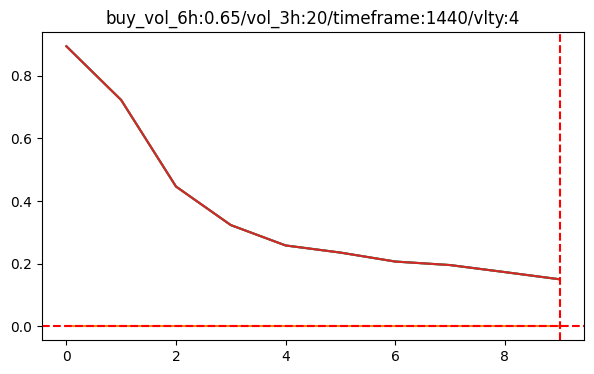

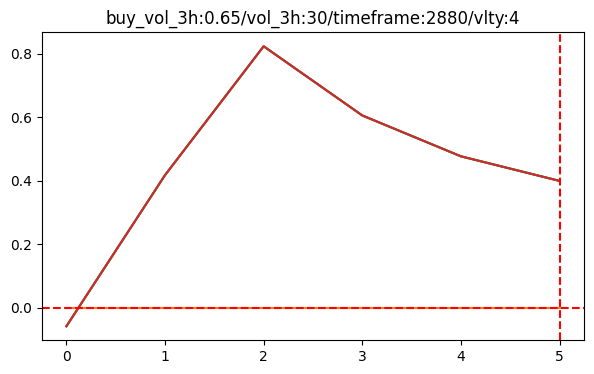

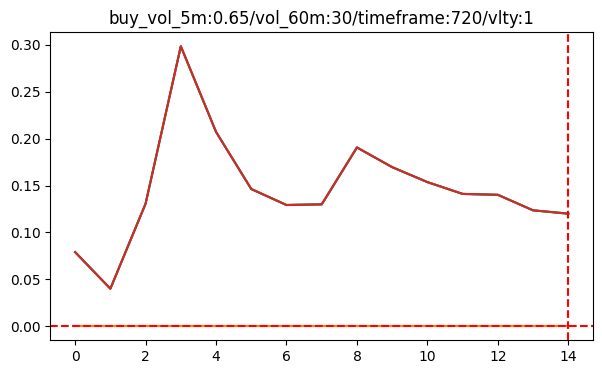

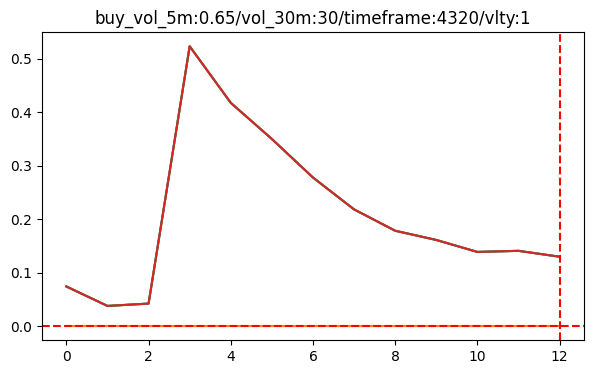

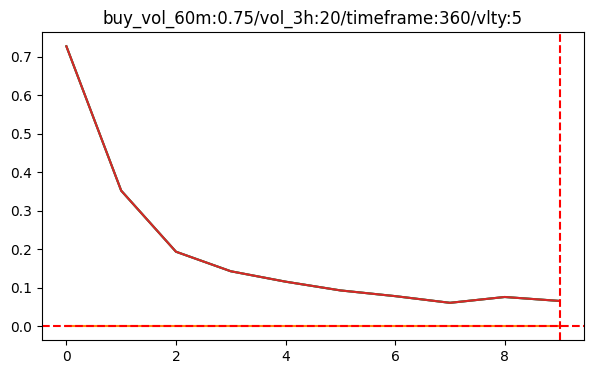

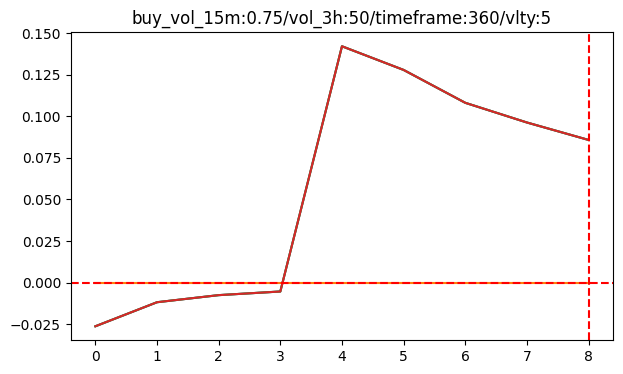

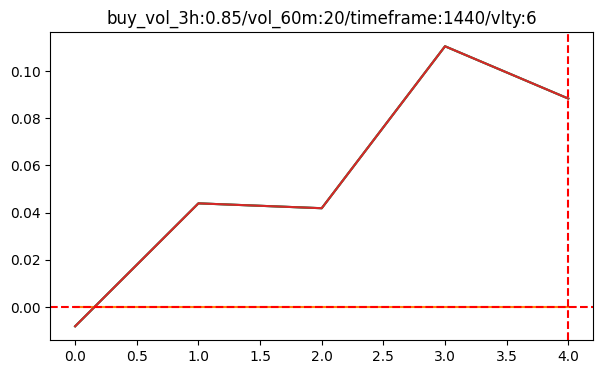

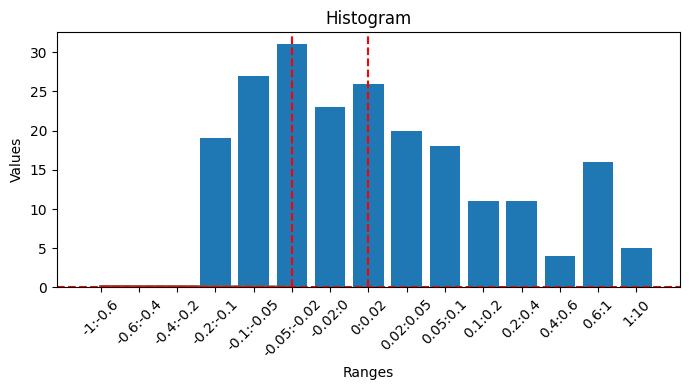

Positive events: 109
Negative events: 102
Biggest Drop: 73.64 at 2023-07-11T17:44:02.870292


,event,mean_series,mean_event,balance,coin,event_key,price_%_1d,price_%_6h,price_%_3h,price_%_1h,buy_price,exit_price,timestamp_exit
0,2023-05-24T05:59:02.689721,0.079037,0.079037,1007.90,ARPAUSDT,buy_vol_5m:0.65/vol_60m:30/timeframe:720/vlty:1,0.5452,0.4679,0.1996,0.1294,0.100080,0.107990,2023-05-24T15:36:02.796321
1,2023-05-24T05:59:02.689721,0.076689,0.074341,1015.33,ARPAUSDT,buy_vol_5m:0.65/vol_30m:30/timeframe:4320/vlty:1,0.5452,0.4679,0.1996,0.1294,0.100080,0.107520,2023-05-26T15:36:02.390903
2,2023-06-04T14:26:02.654283,0.051706,0.001740,1015.50,LUNCUSDT,buy_vol_5m:0.65/vol_30m:30/timeframe:4320/vlty:1,0.1493,0.0949,0.0713,0.0380,0.000098,0.000098,2023-06-07T00:04:02.230400
3,2023-06-04T16:02:02.869399,0.039032,0.001012,1015.60,LUNCUSDT,buy_vol_5m:0.65/vol_60m:30/timeframe:720/vlty:1,0.2830,0.2067,0.1769,0.0363,0.000109,0.000109,2023-06-05T01:39:02.712486
4,2023-06-10T07:44:02.820154,0.072135,0.204545,1036.05,ADAUPUSDT,buy_vol_60m:0.65/vol_6h:10/timeframe:4320/vlty:2,-0.5749,-0.4534,-0.0330,0.0353,0.088000,0.106000,2023-06-12T17:20:02.902514
5,2023-06-10T07:44:02.820154,0.096097,0.215909,1057.64,ADAUPUSDT,buy_vol_60m:0.65/vol_6h:12/timeframe:2880/vlty:2,-0.5749,-0.4534,-0.0330,0.0353,0.088000,0.107000,2023-06-11T22:08:02.896353
6,2023-06-10T07:46:02.780527,0.079122,-0.022727,1055.37,SUSHIUSDT,buy_vol_60m:0.65/vol_6h:10/timeframe:4320/vlty:2,-0.2186,-0.2207,0.0035,0.0381,0.572000,0.559000,2023-06-12T17:23:02.770180
7,2023-06-10T07:46:02.780527,0.069232,0.000000,1055.37,SUSHIUSDT,buy_vol_60m:0.65/vol_6h:12/timeframe:2880/vlty:2,-0.2186,-0.2207,0.0035,0.0381,0.572000,0.572000,2023-06-11T22:10:02.849730
8,2023-06-10T17:41:02.414171,0.060634,-0.008152,1054.55,GNOUSDT,buy_vol_3h:0.85/vol_60m:20/timeframe:1440/vlty:6,-0.0604,0.0128,0.0101,0.0119,110.400000,109.500000,2023-06-11T12:53:02.532959
9,2023-06-11T02:41:02.880311,0.053856,-0.007141,1053.84,STPTUSDT,buy_vol_5m:0.85/vol_60m:50/timeframe:2880/vlty:4,-0.1083,0.0107,0.0032,-0.0068,0.035010,0.034760,2023-06-12T17:06:02.835604


In [14]:
from Functions import analyzeRiskManagementPerformance

riskmanagement_path = "/Users/albertorainieri/Projects/Personal/analysis/riskmanagement_backup/riskmanagement-2023-10-9-[50, 35, 25, 15, 10, 5]-3-713.json"
OPTIMIZED=True
DISCOVER=False

event_investment_amount=100


df, biggest_drop, biggest_drop_date, positive_outcome, negative_outcome, PERFORMANCE_SCENARIOS = analyzeRiskManagementPerformance(riskmanagement_path, OPTIMIZED, DISCOVER, event_investment_amount)
import pandas as pd
pd.set_option('display.max_rows', 1000)
print(f'Positive events: {positive_outcome}')
print(f'Negative events: {negative_outcome}')
print(f'Biggest Drop: {biggest_drop} at {biggest_drop_date}')

df

['buy_vol_60m:0.65/vol_6h:10/timeframe:4320/vlty:2', 'buy_vol_60m:0.65/vol_6h:12/timeframe:4320/vlty:2', 'buy_vol_30m:0.75/vol_6h:10/timeframe:4320/vlty:2', 'buy_vol_5m:0.85/vol_60m:50/timeframe:2880/vlty:4', 'buy_vol_6h:0.65/vol_3h:20/timeframe:1440/vlty:4', 'buy_vol_3h:0.75/vol_60m:15/timeframe:360/vlty:3', 'buy_vol_3h:0.75/vol_30m:30/timeframe:720/vlty:3', 'buy_vol_5m:0.65/vol_30m:30/timeframe:720/vlty:1', 'buy_vol_5m:0.65/vol_30m:30/timeframe:4320/vlty:1', 'buy_vol_3h:0.85/vol_60m:20/timeframe:1440/vlty:6', 'buy_vol_3h:0.65/vol_6h:20/timeframe:720/vlty:5', 'buy_vol_15m:0.85/vol_3h:12/timeframe:4320/vlty:7']
KEY NOT PRESENT: buy_vol_3h:0.75/vol_60m:10/timeframe:720/vlty:3
KEY NOT PRESENT: buy_vol_5m:0.65/vol_60m:30/timeframe:720/vlty:1
KEY NOT PRESENT: buy_vol_60m:0.65/vol_6h:12/timeframe:2880/vlty:2
KEY NOT PRESENT: buy_vol_3h:0.65/vol_3h:20/timeframe:2880/vlty:4
KEY NOT PRESENT: buy_vol_3h:0.75/vol_60m:15/timeframe:720/vlty:3
KEY NOT PRESENT: buy_vol_30m:0.75/vol_6h:10/timeframe:2

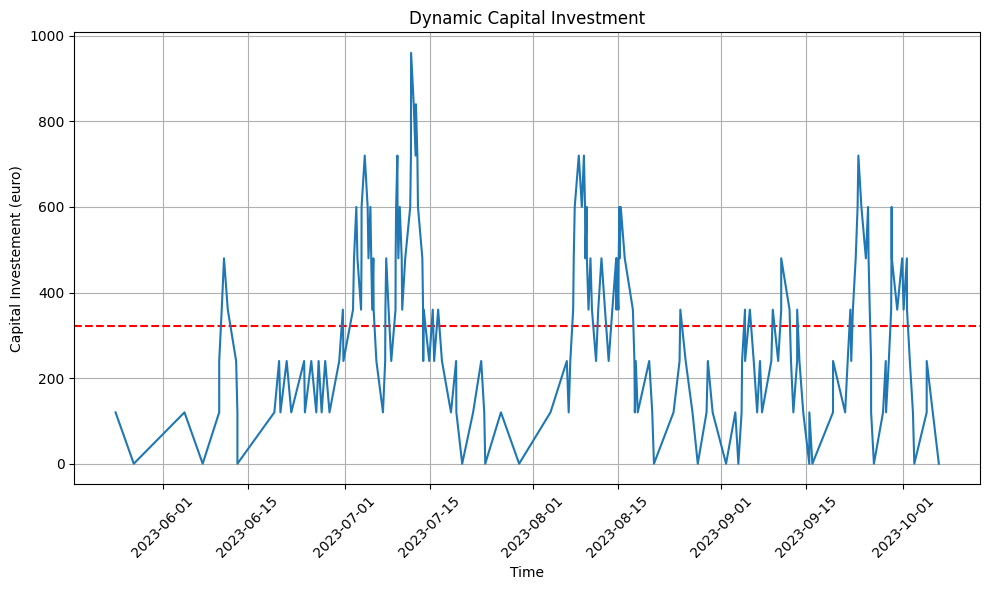

In [15]:
from Functions import check_invevestment_amount
riskmanagement_path = "/Users/albertorainieri/Projects/Personal/analysis/riskmanagement_backup/riskmanagement-2023-9-27-[50, 35, 25, 15, 5]-3-212.json"
check_invevestment_amount(info, output, investment_amount=120, riskmanagement_path=riskmanagement_path)

In [ ]:
PERFORMANCE_SCENARIOS